### Summary 
Functions for evaluation of image enhancement 
* Local Similarity ( LS )
* Structural Similarity Index Matching ( SSIM )
* Multi Scale Structural Similarity Index Matching ( MS-SSIM )
* Peak Signal to Noise Ration ( PSNR )
* Frequency Spectra Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# reading images 
file_image_gt = './sample_images/seismic_1_GT.png'

image_gt = imageio.v3.imread(file_image_gt)


In [ ]:
image_gt = tf.Variable(image_gt)


In [ ]:
image_gt = tf.cast(image_gt, tf.dtypes.float32) / 255.

In [ ]:
# metrics
noise_factor = 0.5 
image_lr = image_gt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image_gt.shape) 

print('Peak SNR', tf.image.psnr(image_gt,image_lr, max_val=1.0).numpy())
print('SSIM', tf.image.ssim(image_gt,image_lr, max_val=1.0).numpy())
print('MS-SSIM', tf.image.ssim_multiscale(image_gt,image_lr, max_val=1.0).numpy())

In [ ]:
# visualisation

plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
plt.imshow(image_gt, cmap='gray')
ax.set_title('Ground Truth Image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
plt.imshow(image_lr, cmap='gray')
ax.set_title('LR Image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
metrics = {
    'noise_factor' : [], 
    'psnr' : [], 
    'ssim' : [], 
    'ms_ssim' : []
}

for i in range(1,20) : 
    noise_factor = 0.05 * i
    metrics['noise_factor'].append(noise_factor)
    noisy_image = image_gt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = image_gt.shape)
    metrics['psnr'].append(tf.image.psnr(image_gt, noisy_image,max_val=1.0).numpy())
    metrics['ssim'].append(tf.image.ssim(image_gt,noisy_image,max_val=1.0).numpy())
    metrics['ms_ssim'].append(tf.image.ssim_multiscale(image_gt,noisy_image, max_val=1.0))



plt.figure(figsize=(20,6))
plt.plot(metrics['noise_factor'], metrics['psnr'], label='psnr' )
plt.plot(metrics['noise_factor'], metrics['ssim'], label='ssim' )
plt.plot(metrics['noise_factor'], metrics['ms_ssim'], label='ms-ssim' )
plt.xlabel('noise_factor')
plt.ylabel('metric')
plt.legend()
plt.show()

### Image Enhancement Factor

Image Enhancement Factor (IEF)=MSE(Original Image, Noise Image) / MSE (Original Image, Restored Image)

In [ ]:
def ief(image_original, image_noisy, image_restored) : 
   mse_noisy = tf.reduce_mean(tf.keras.losses.mean_squared_error(image_original, image_noisy)).numpy() 
   mse_restored = tf.reduce_mean(tf.keras.losses.mean_squared_error(image_original, image_restored)).numpy()

   return mse_noisy / mse_restored

image_noisy = image_gt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = image_gt.shape)
print(ief(image_gt,image_noisy, image_noisy))

### Frequency Spectra Comparison

In [41]:
import sys 
sys.path.append('../data')
sys.path.append('../utils')
sys.path.append('../config')

import matplotlib.pyplot as plt

from segy_input import load_seisnc
from utils_birnie_2021 import fspectra

In [42]:
CLEAN_SEISNC_PATH = '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RND.seisnc'
NOISY_SEISNC_PATH = '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.1.seisnc'
DENOISED_SEISNC_PATH = '/local1/workspace/random_denoising/data/mp41b_pstm_stk_rnd/MP41B_PSTM_STK_RNDnoisy_0.1denoised.seisnc'

In [43]:
clean = load_seisnc(CLEAN_SEISNC_PATH)
noisy = load_seisnc(NOISY_SEISNC_PATH)
denoised = load_seisnc(DENOISED_SEISNC_PATH)

In [44]:
ilines = clean['iline'].values
ilines

array([1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160,
       1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193,
       1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204,
       1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215,
       1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226,
       1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237,
       1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248,
       1249, 1250], dtype=uint16)

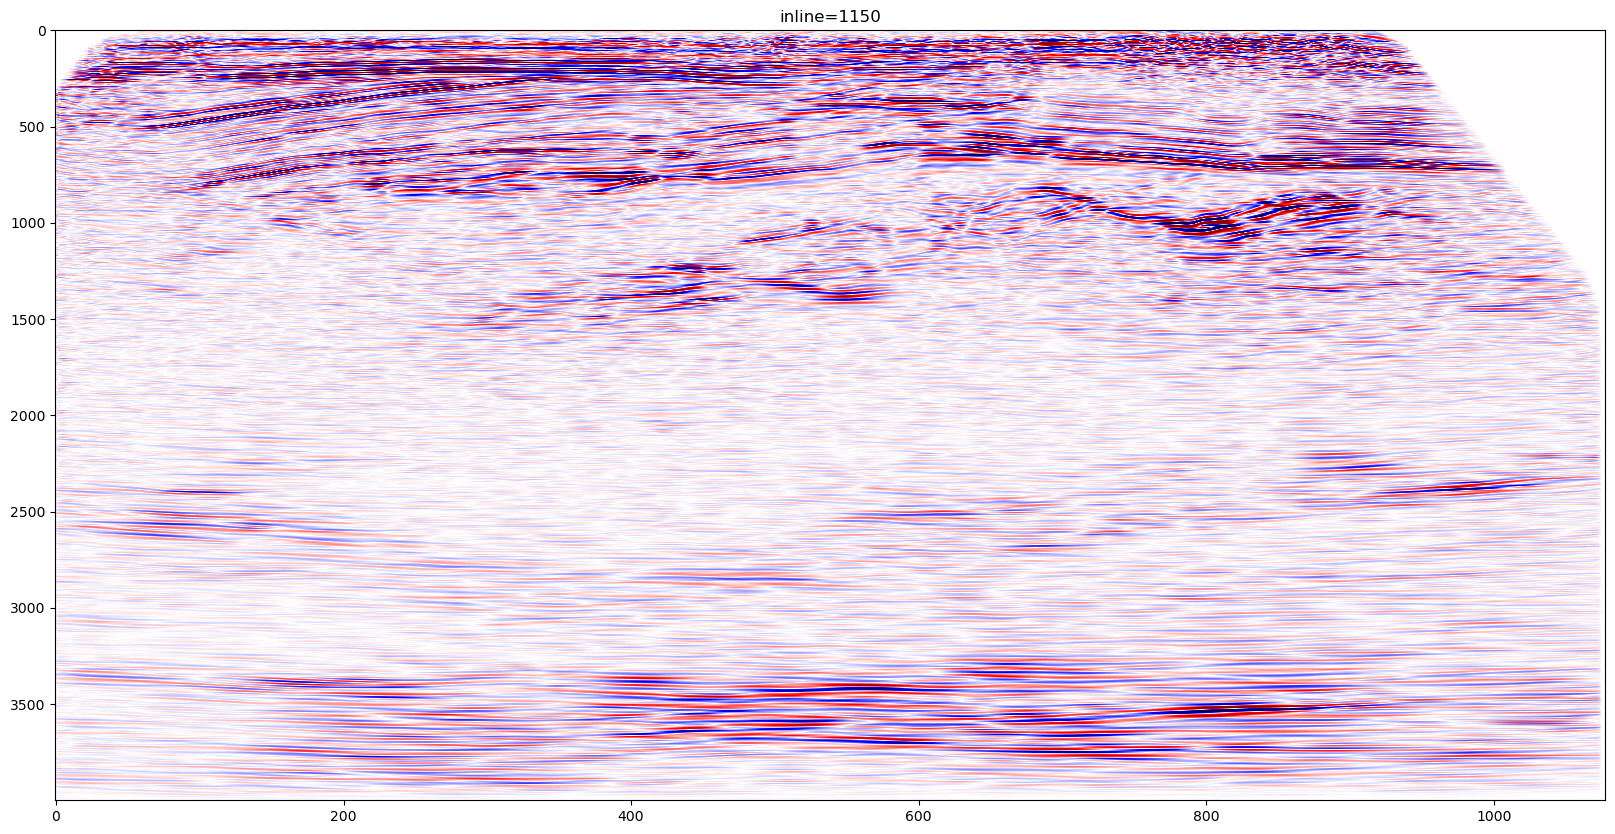

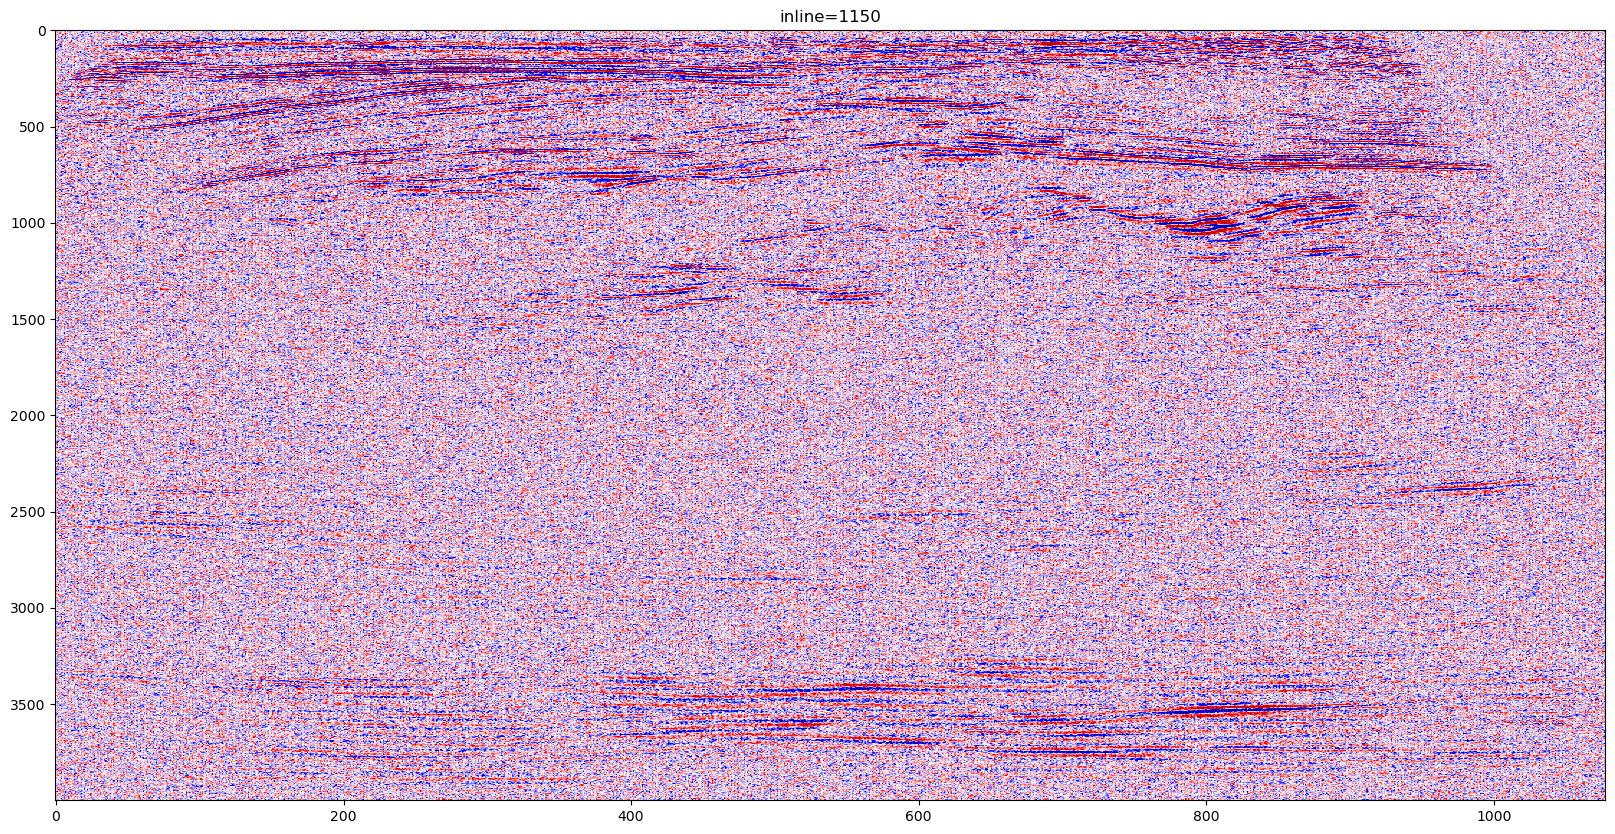

In [53]:
import numpy as np
from skimage.util import random_noise

iline_no = 1150 
iline = clean.sel(iline=iline_no).transpose('twt','xline')

abs_max = abs(iline).quantile(0.99)

abs_max_ = abs_max.compute().data

iline = iline.clip(-abs_max, abs_max)

iline_norm = iline / abs_max

def add_noise(data) : 
    args = dict(mode = 'gaussian', seed=42, clip=True, mean =0 , var = 0.5)
    return random_noise(data, **args)

iline_norm_noisy = iline_norm.map(add_noise )

plt.figure(figsize=(20,10))
plt.title('inline=' + str(iline_no))
plt.imshow(iline_norm.data, cmap='seismic', aspect='auto', vmin=-1, vmax = 1)
plt.show()

plt.figure(figsize=(20,10))
plt.title('inline=' + str(iline_no))
plt.imshow(iline_norm_noisy.data, cmap='seismic', aspect='auto',vmin=-1, vmax = 1)
plt.show()

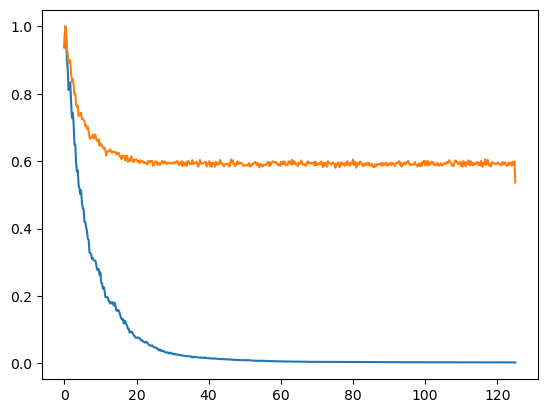

In [57]:
f_clean, a_clean = fspectra(iline_norm.data, dt=4)
f_noisy, a_noisy = fspectra(iline_norm_noisy.data, dt=4)

plt.figure()
plt.plot(f_clean,a_clean/max(a_clean))
plt.plot(f_noisy , a_noisy/ max(a_noisy))
plt.show()

In [47]:
def spectra_iline(seisnc, iline_no) : 
    iline = seisnc.sel(iline=iline_no).transpose('twt','xline')

    abs_max = abs(iline).quantile(0.999)

    abs_max_ = abs_max.compute().data

    iline = iline.clip(-abs_max, abs_max)

    iline_norm = iline / abs_max

    f, a = fspectra(iline_norm.data, dt=4)

    return f,a

In [48]:
def plot_spectra_iline(seisnc, iline_no) : 

    f,a = spectra_iline(seisnc, iline_no)    

    plt.figure(figsize=(8,8))
    plt.title("Avg Real Amp Freq Spectrum, IL #" + str(iline_no))
    plt.plot(f,a/max(a)) # normalised values
    plt.show()

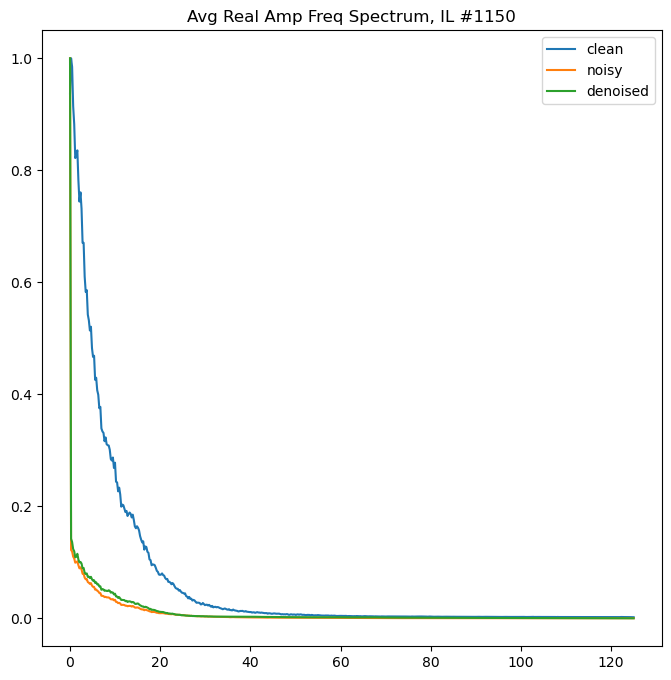

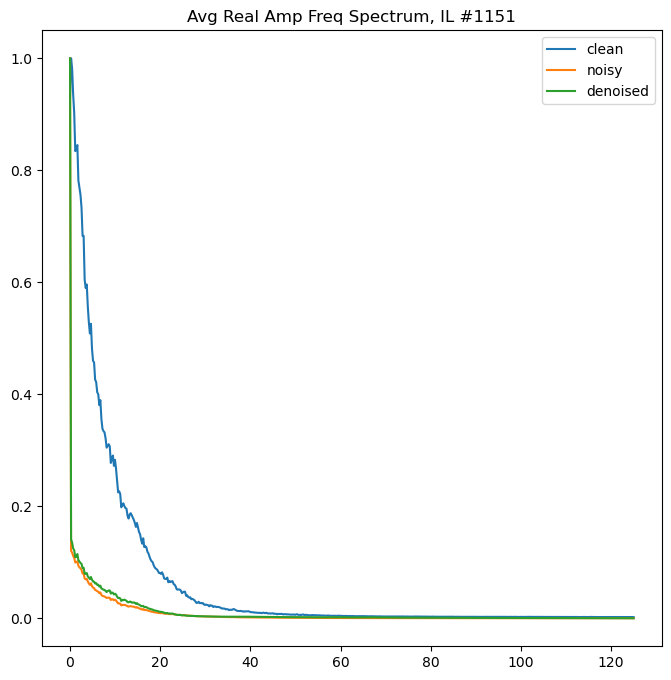

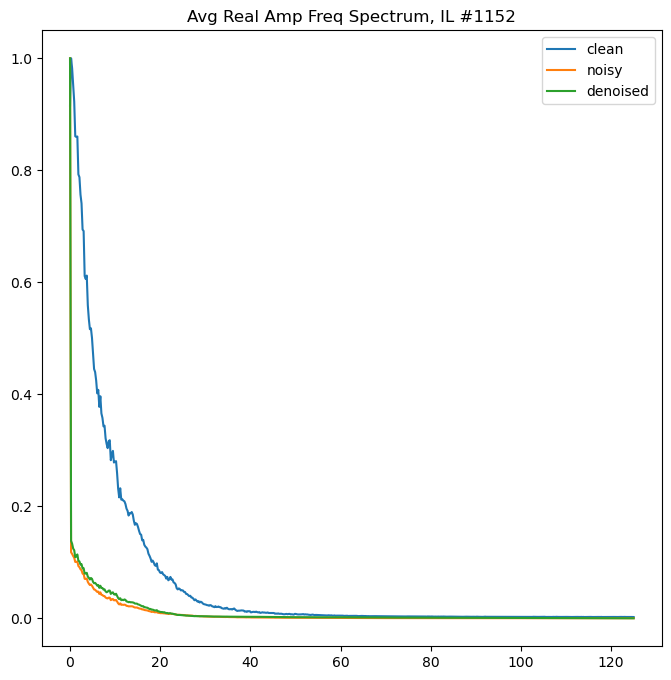

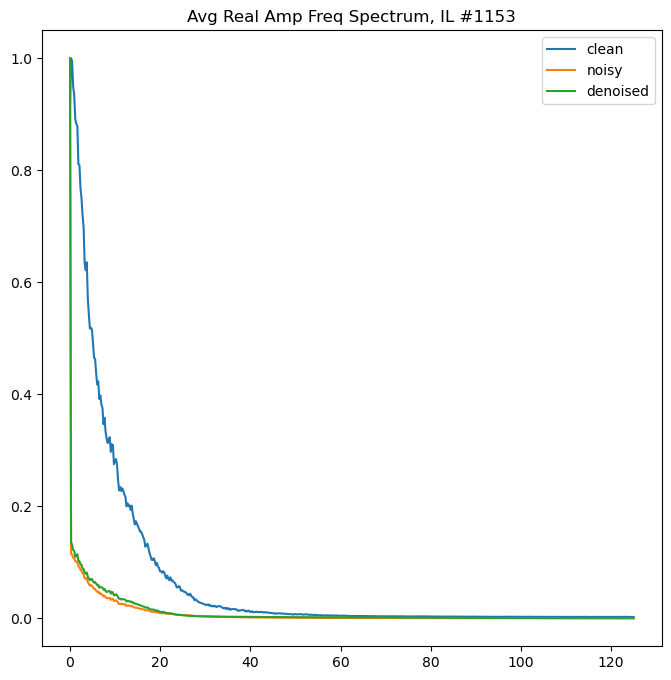

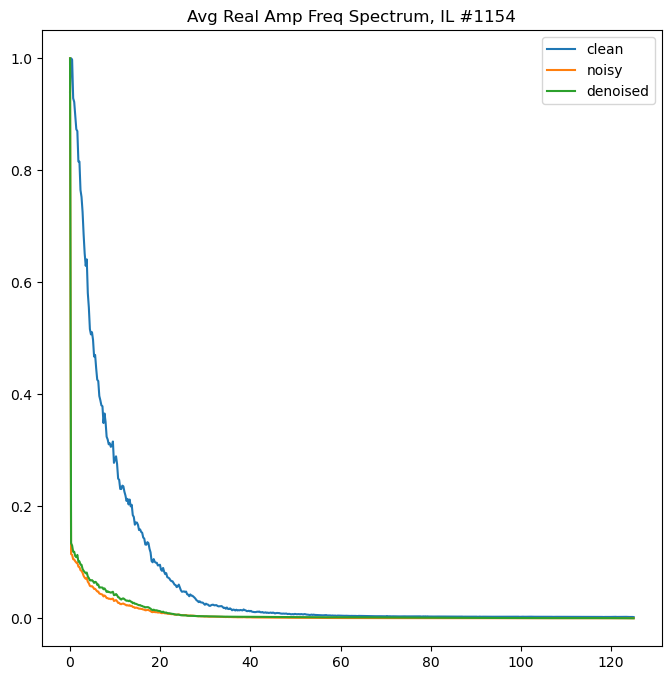

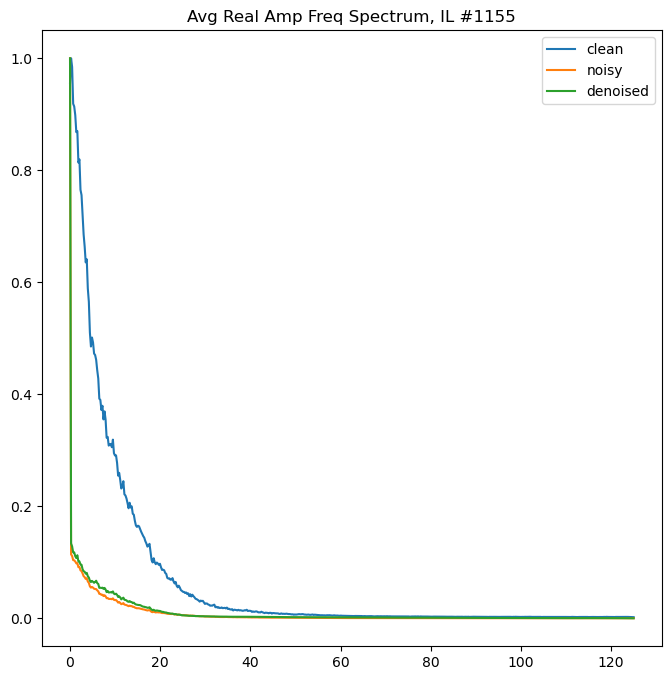

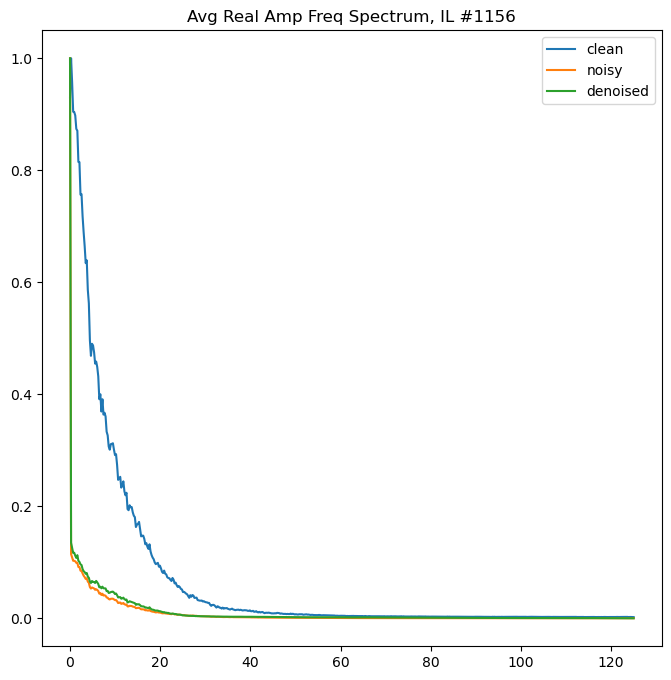

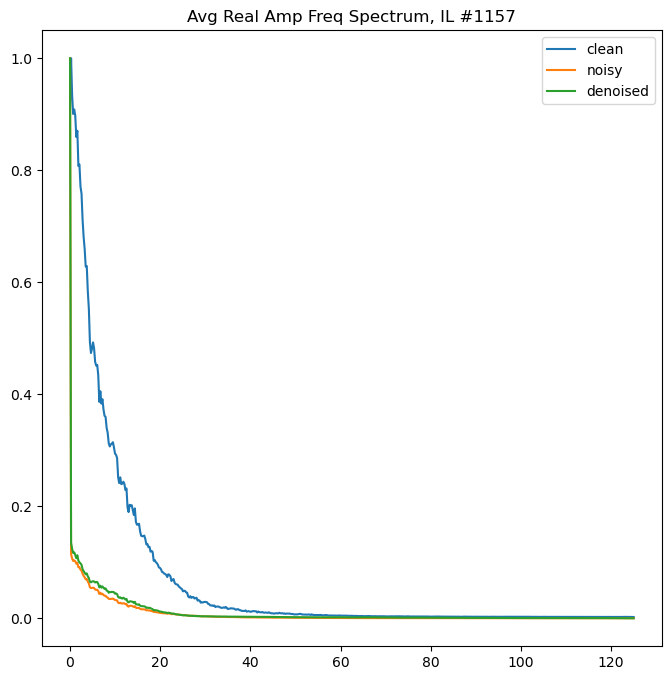

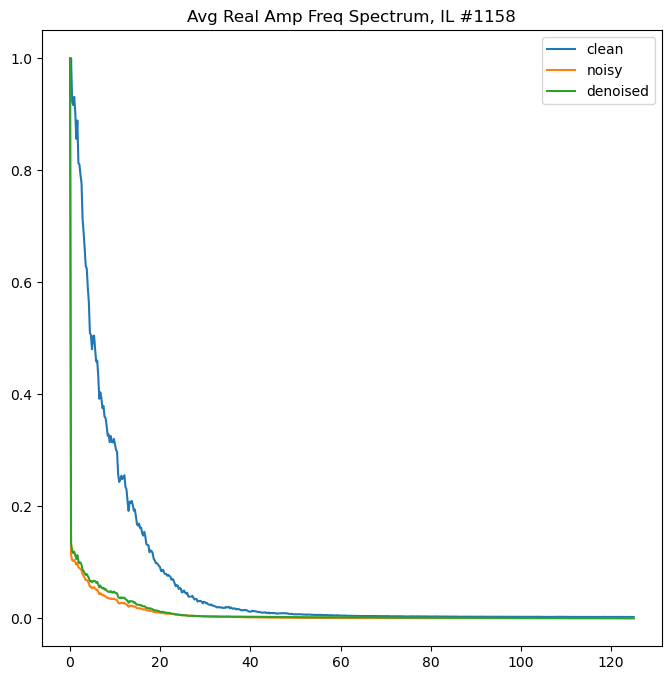

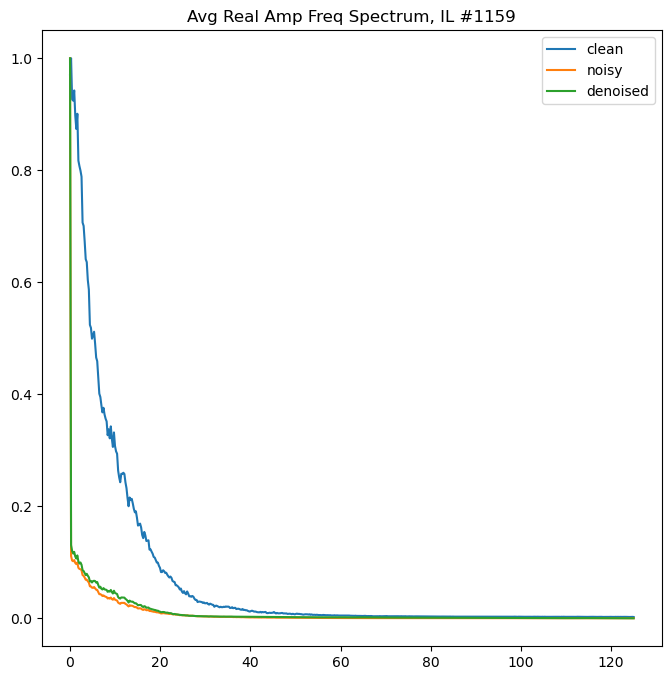

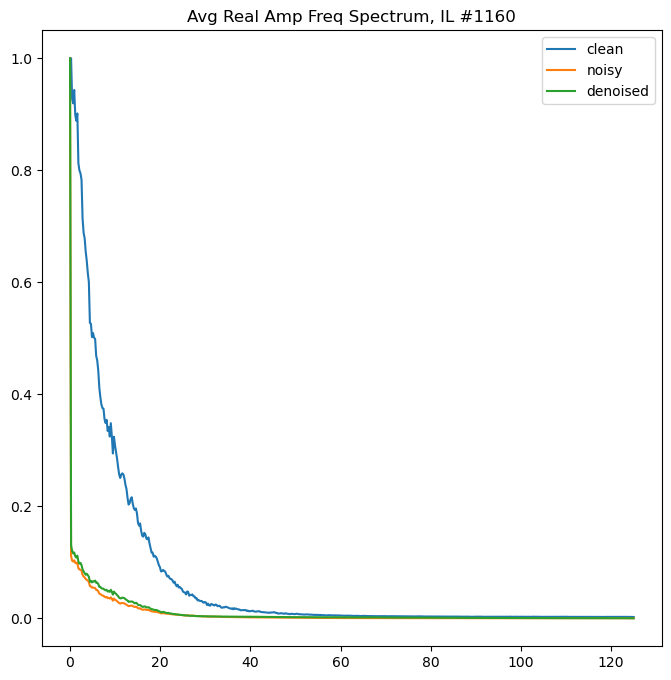

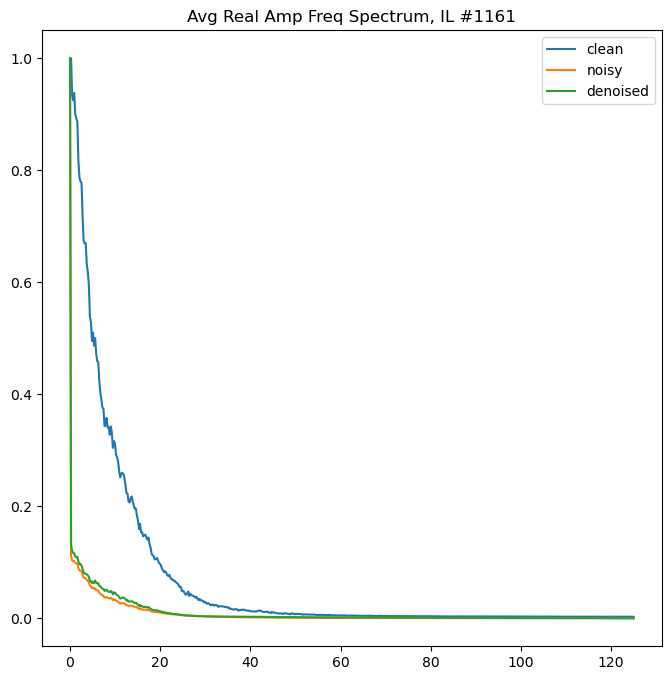

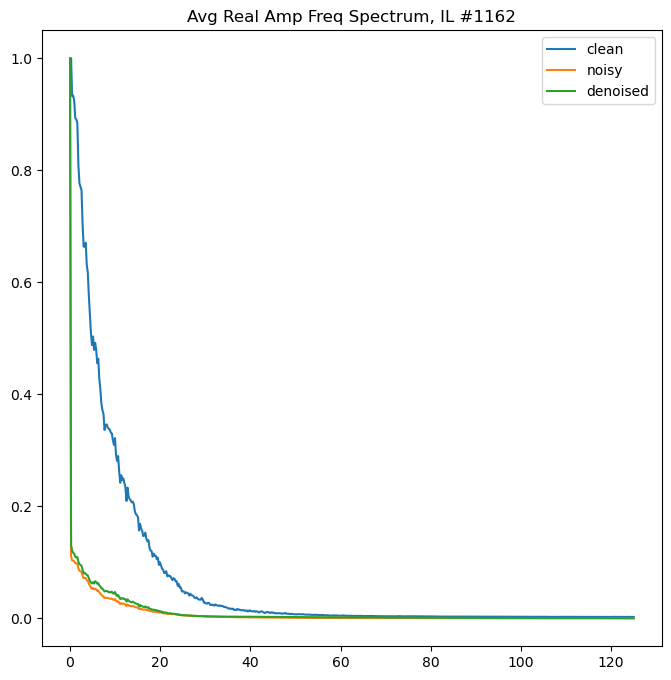

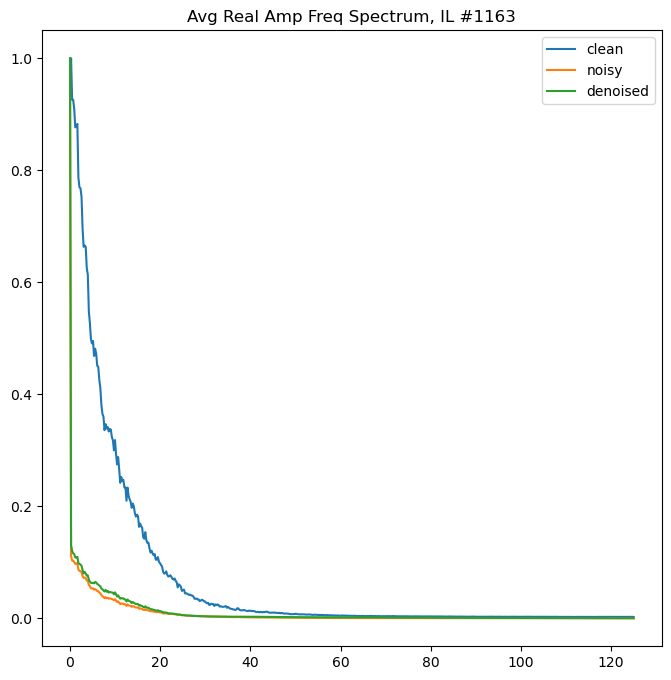

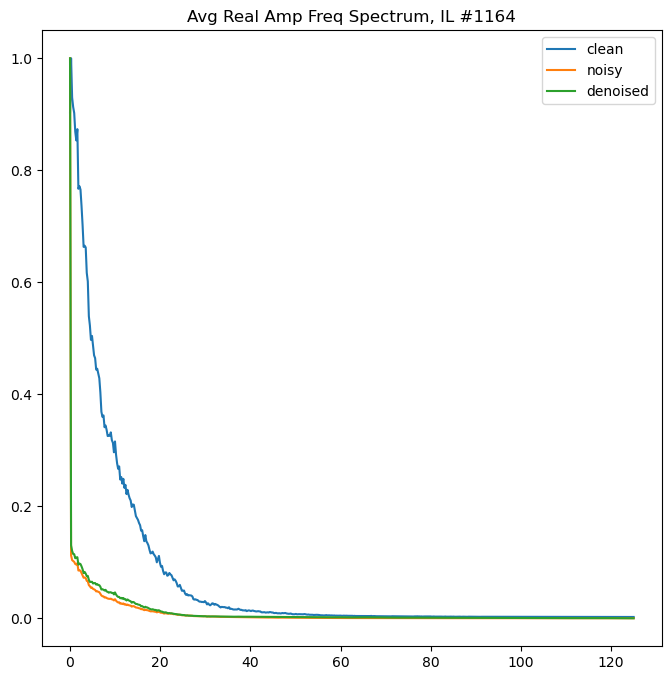

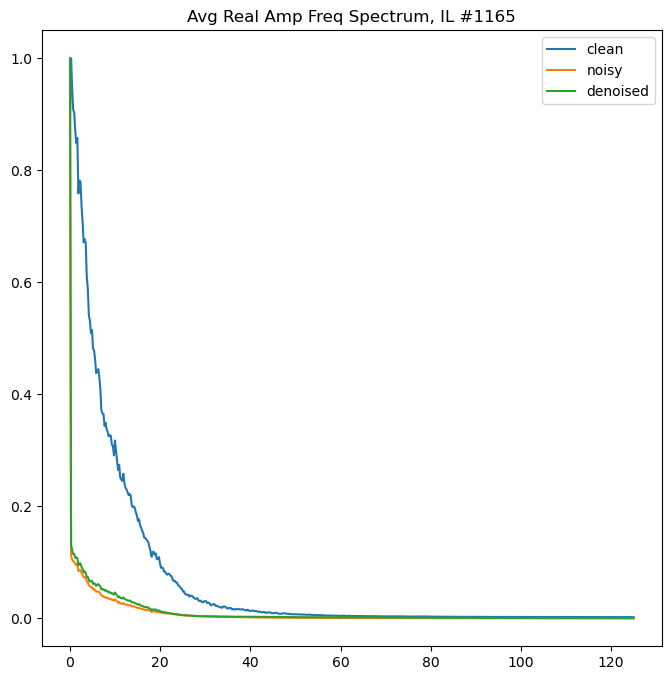

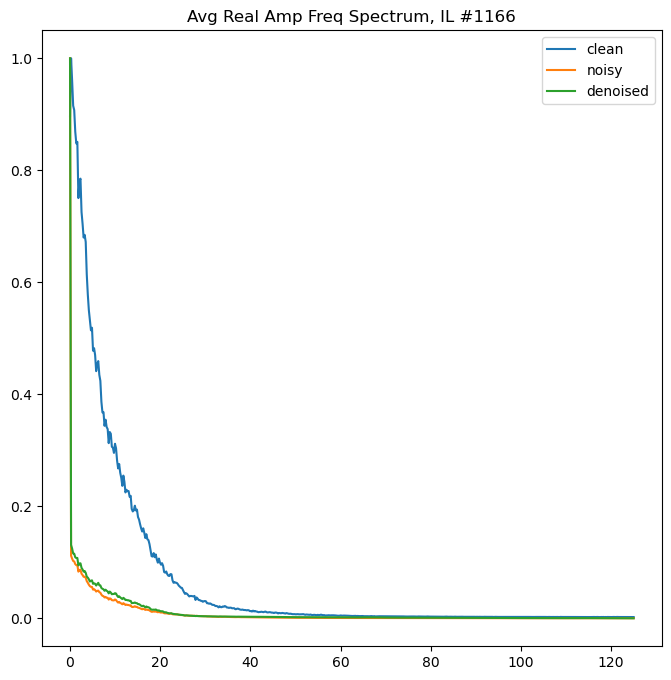

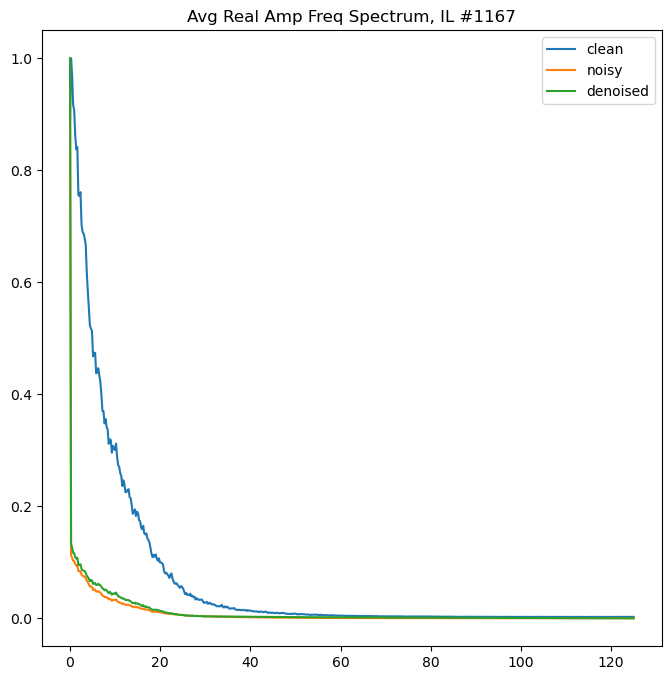

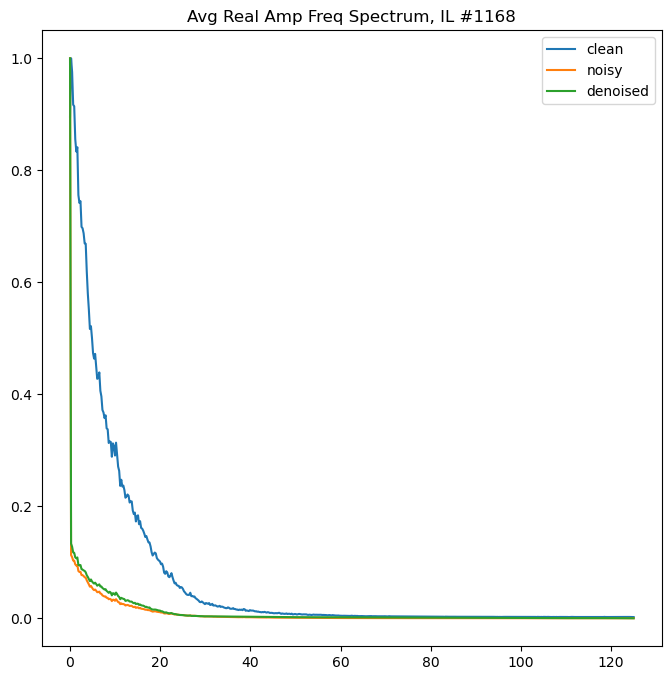

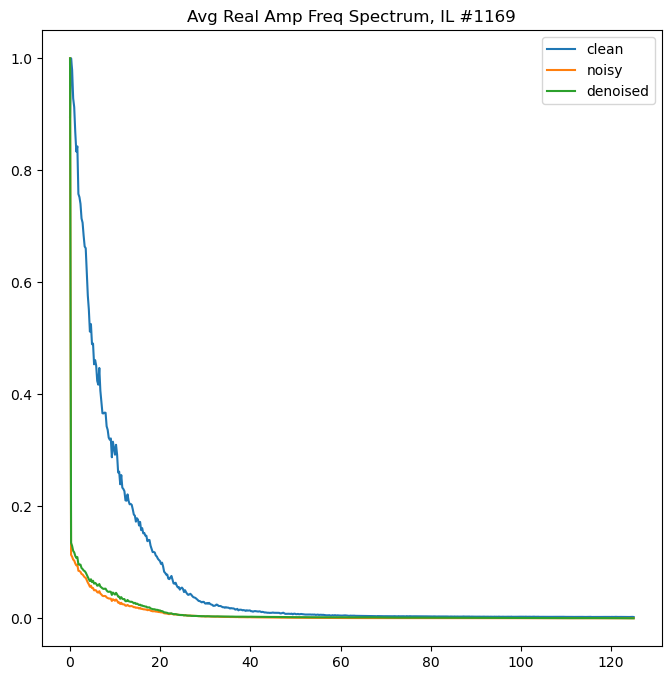

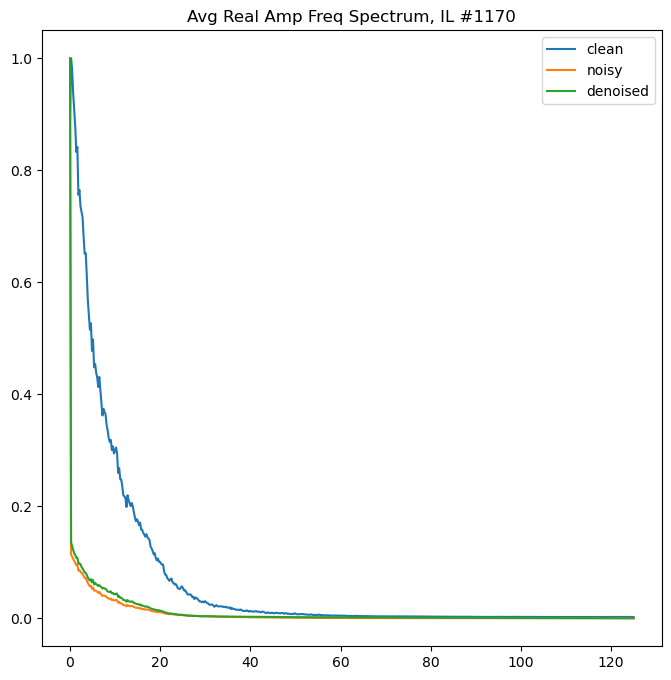

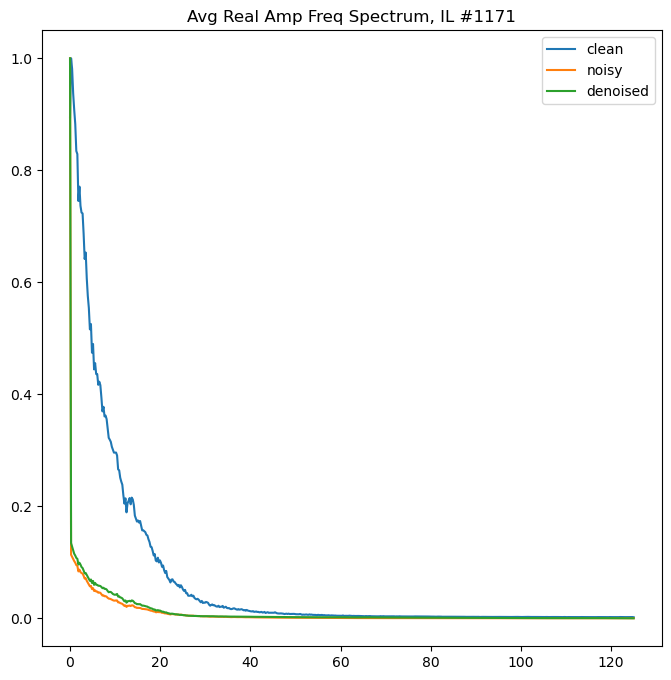

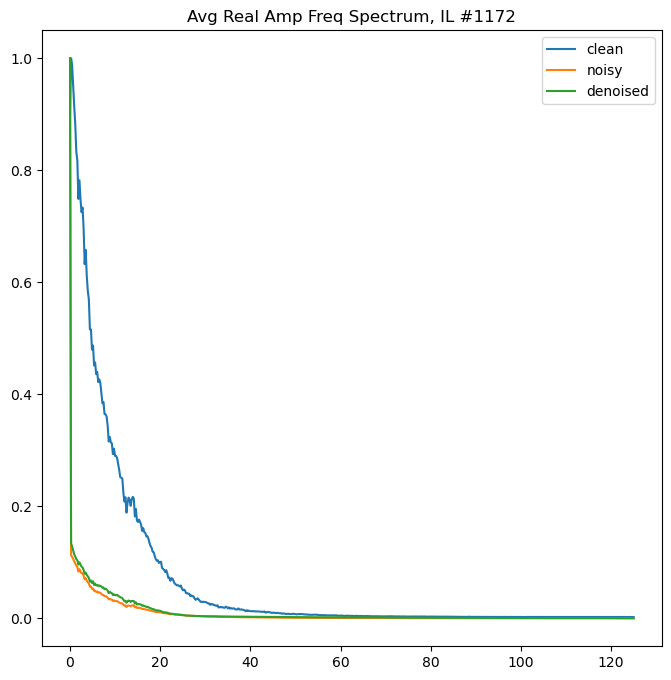

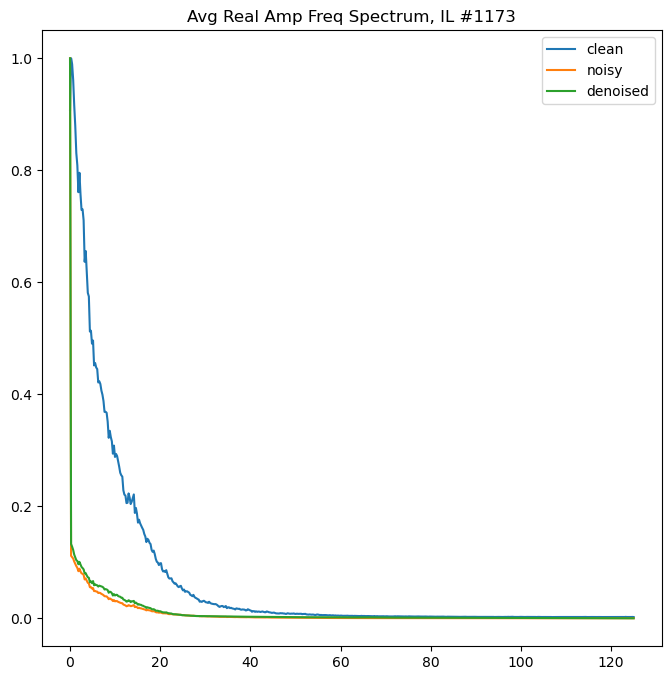

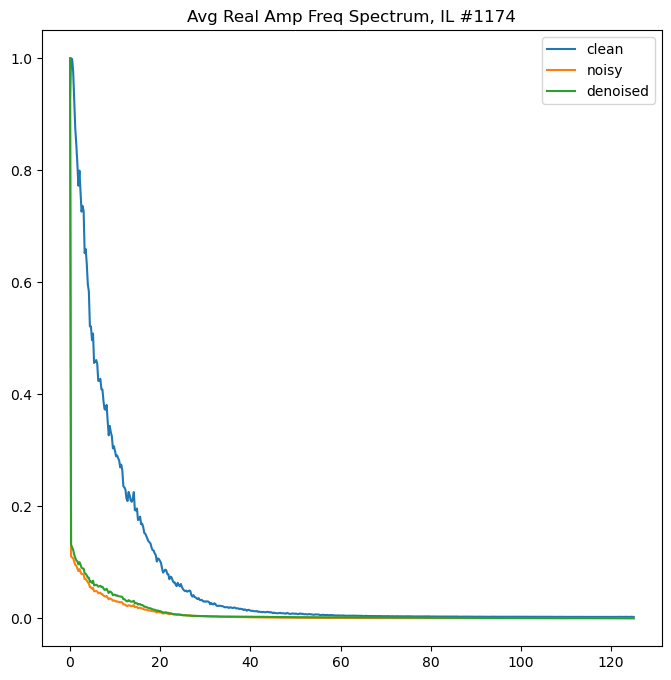

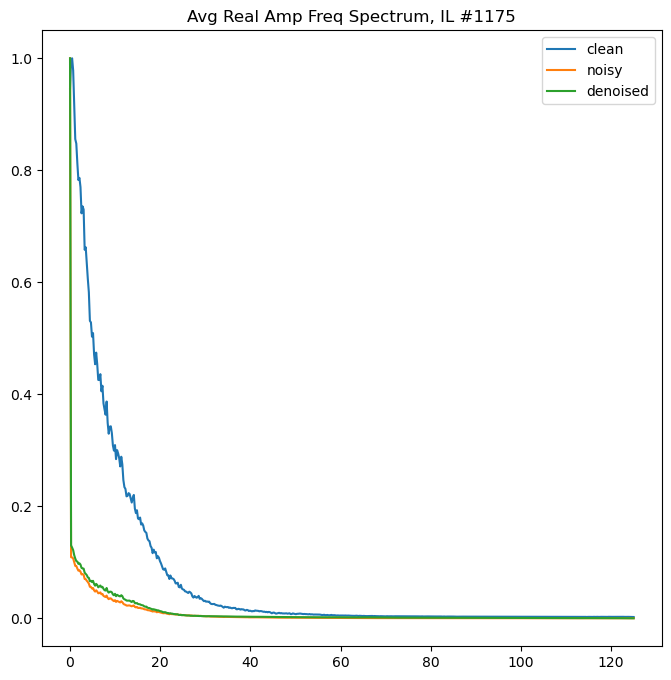

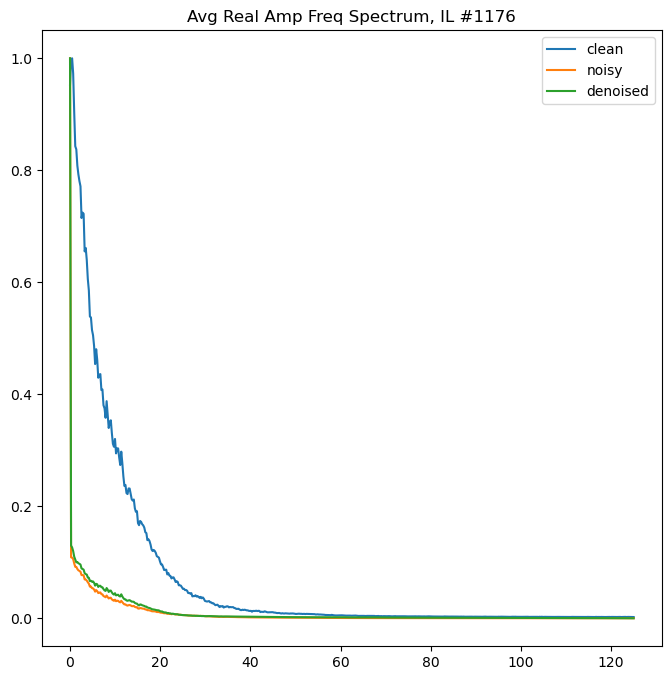

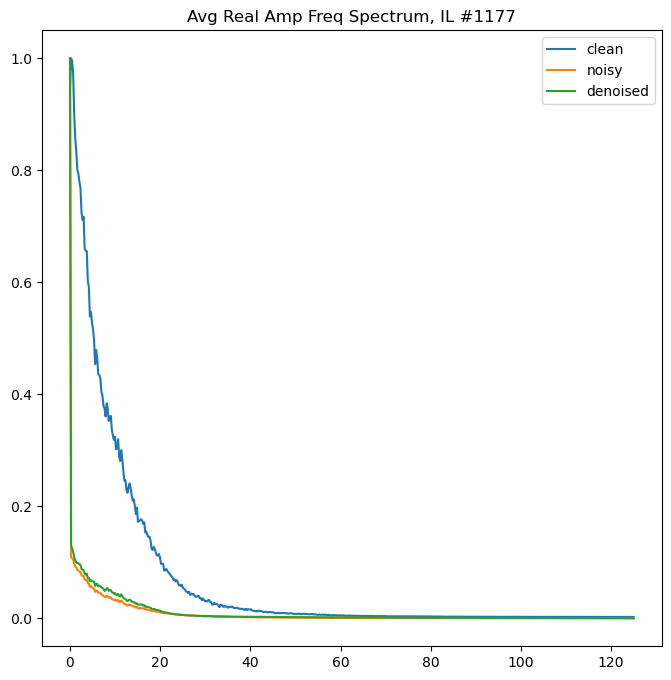

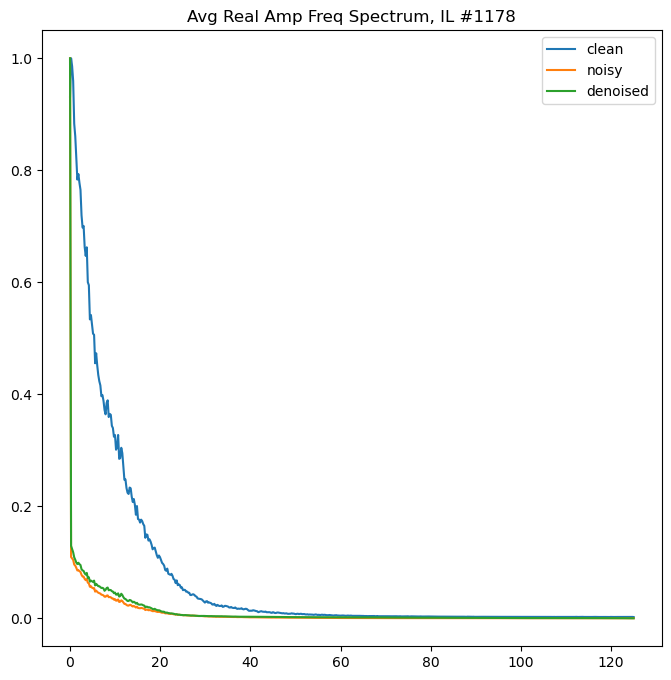

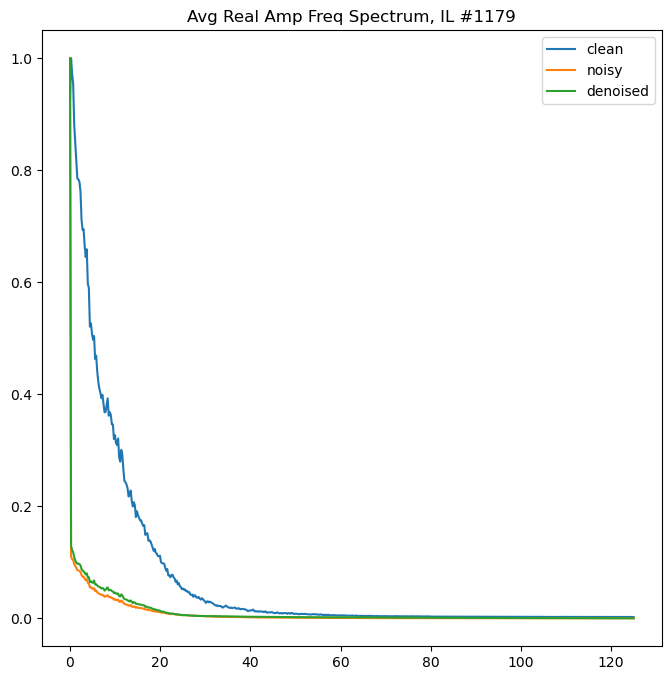

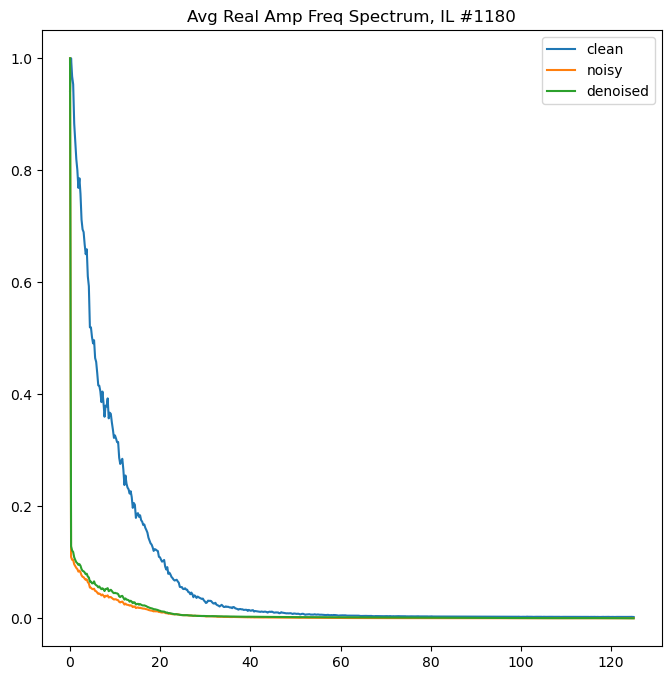

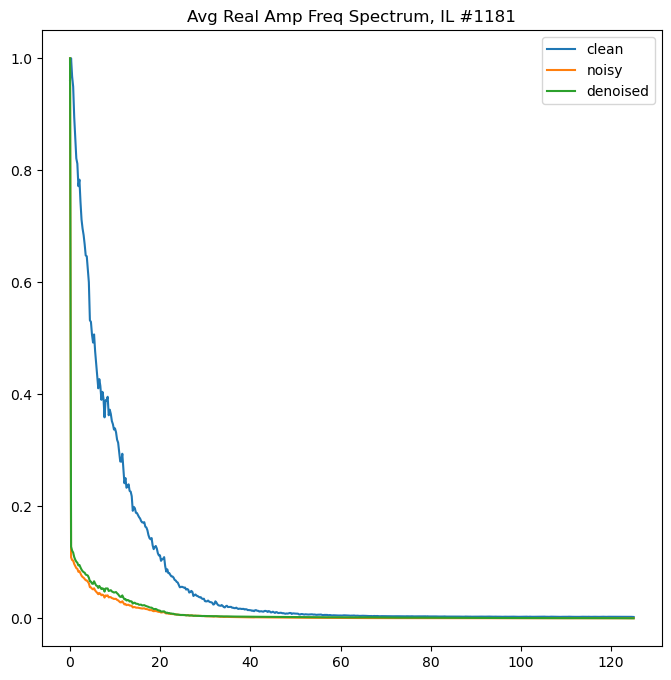

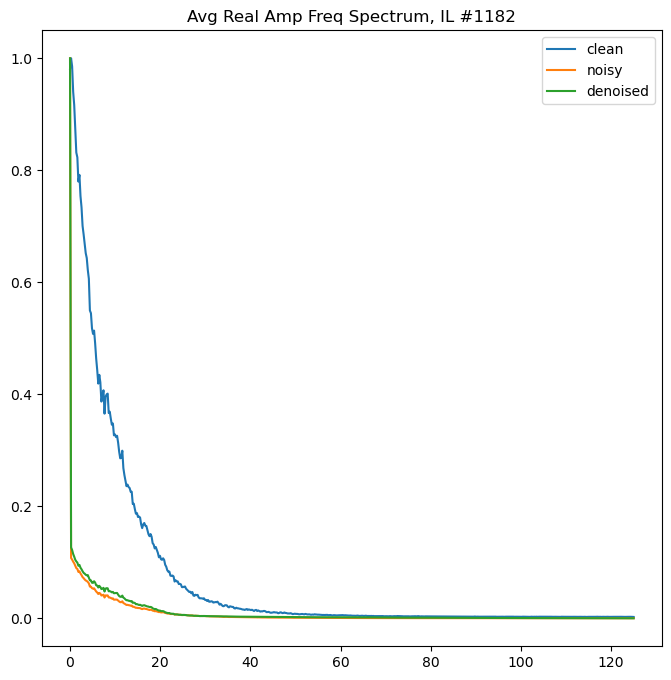

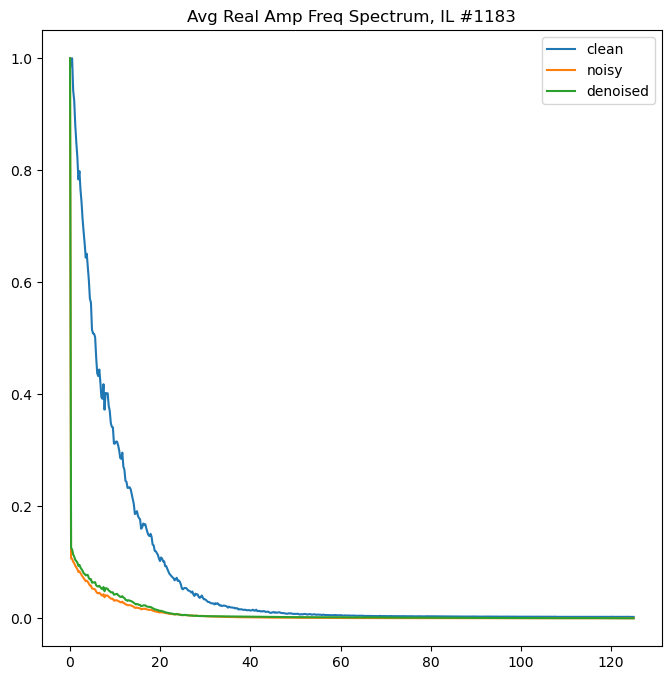

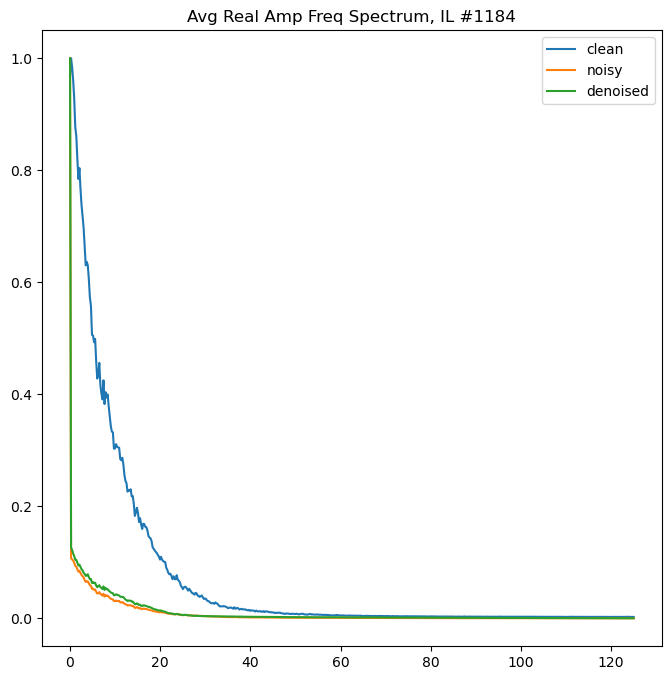

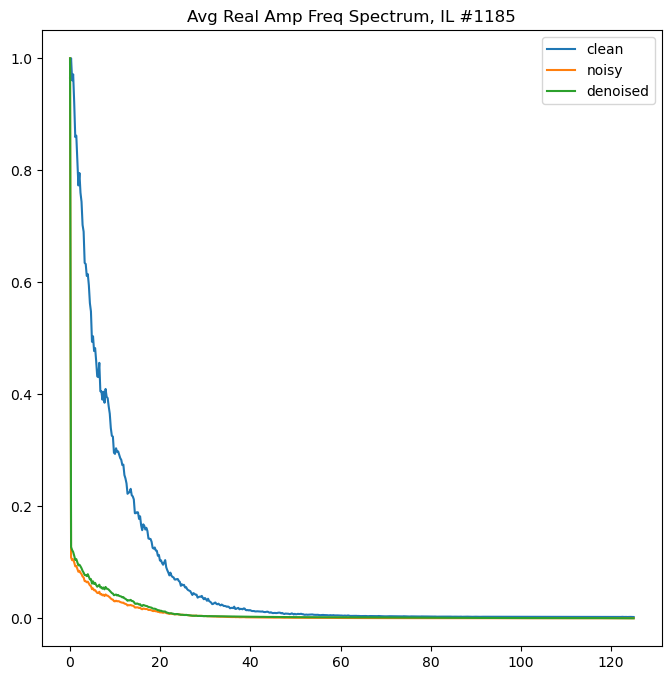

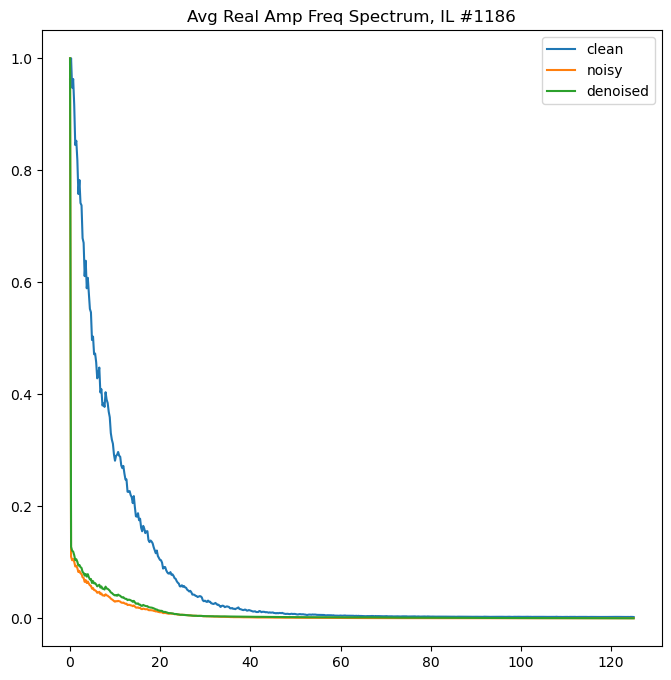

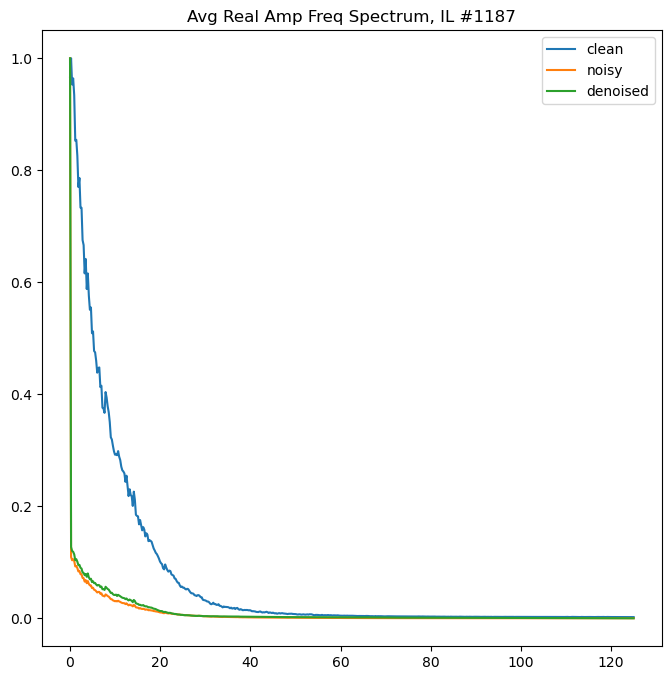

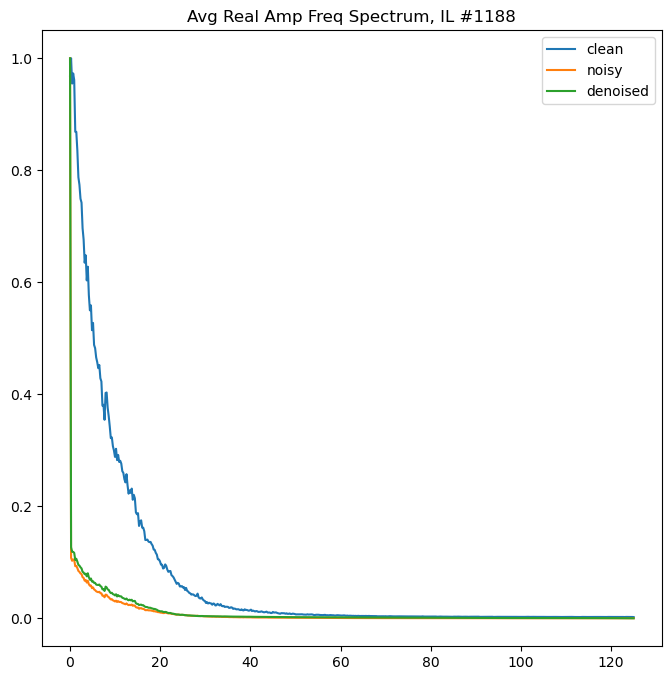

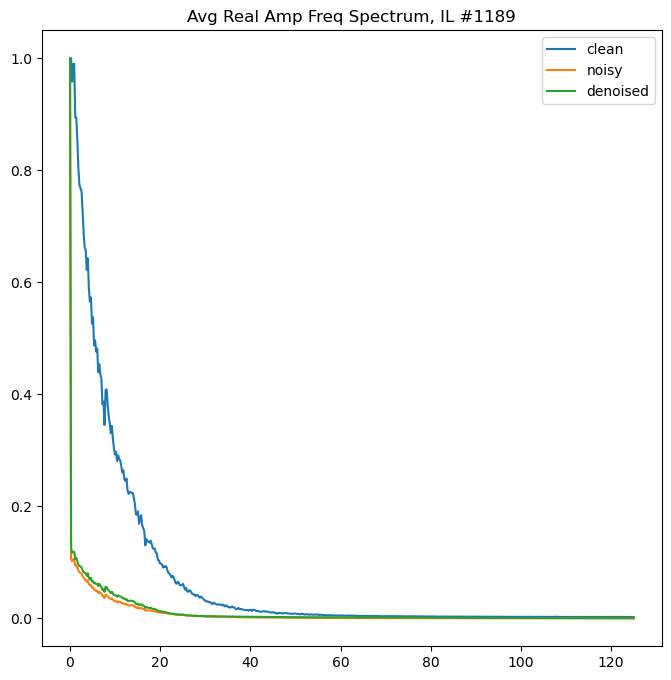

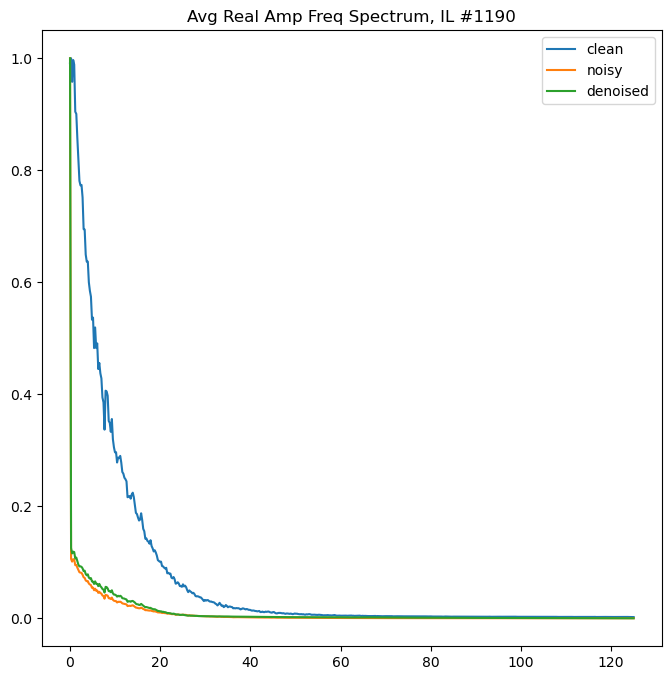

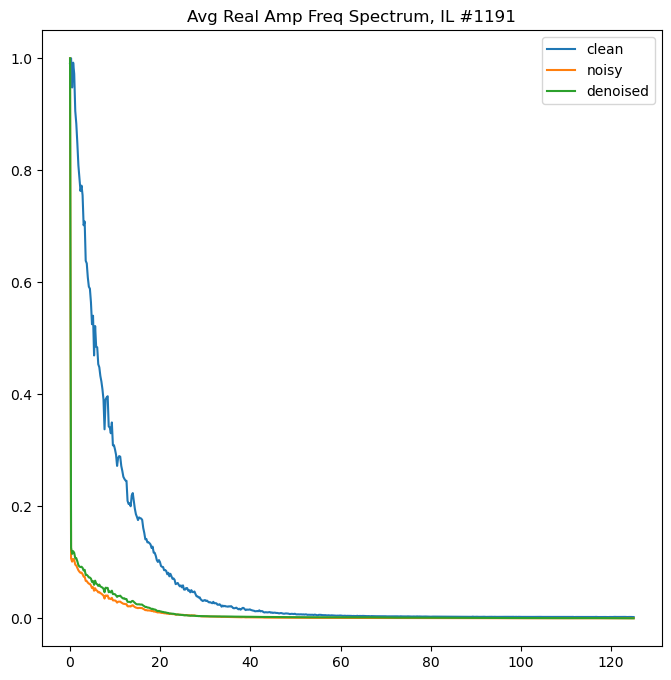

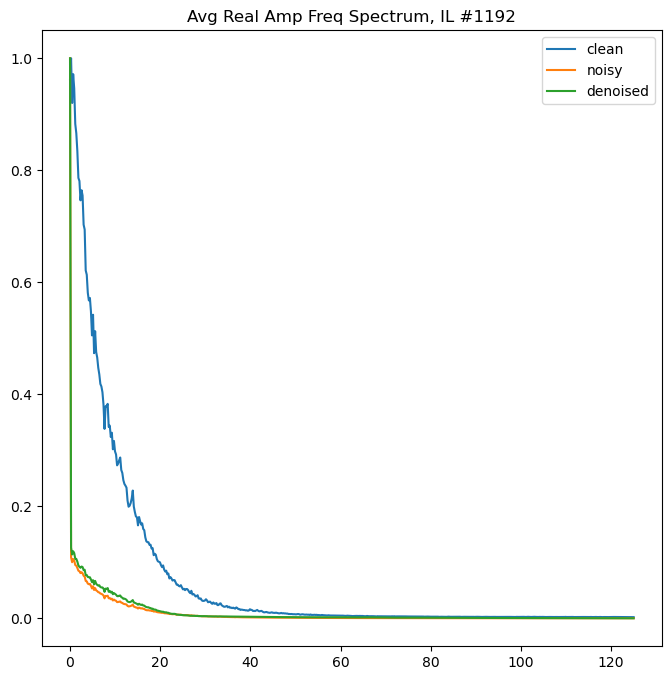

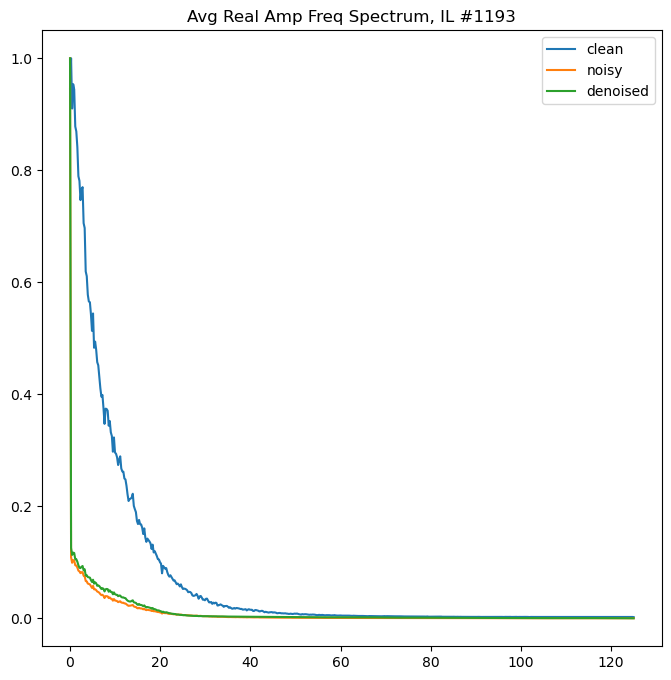

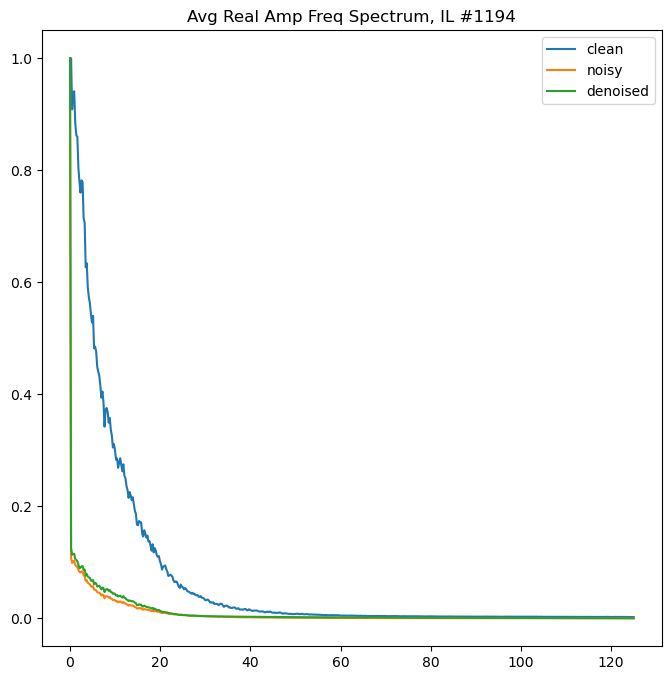

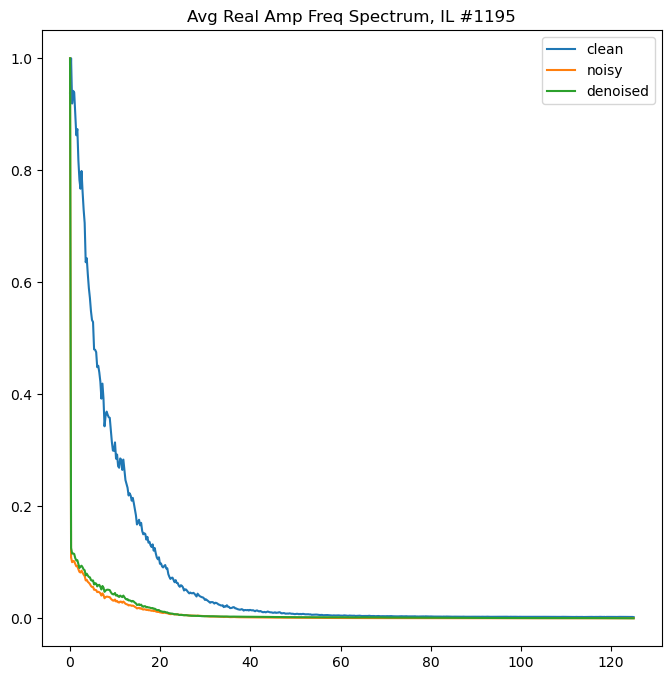

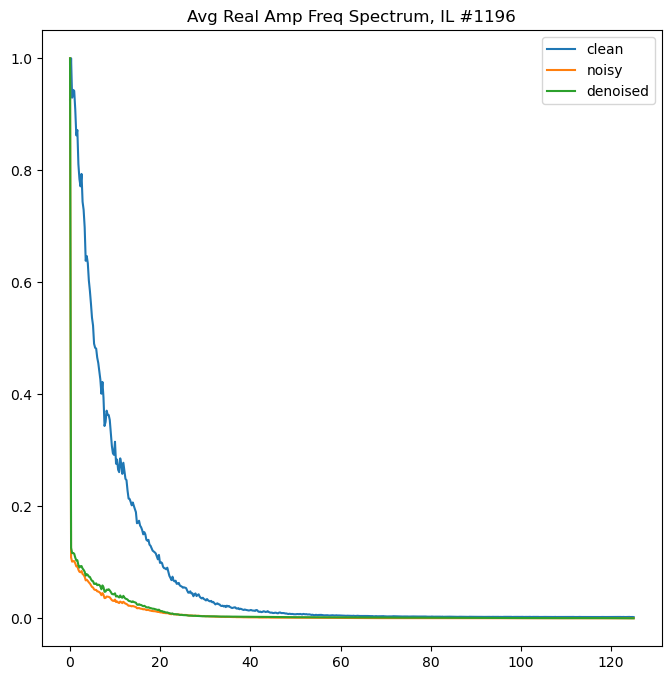

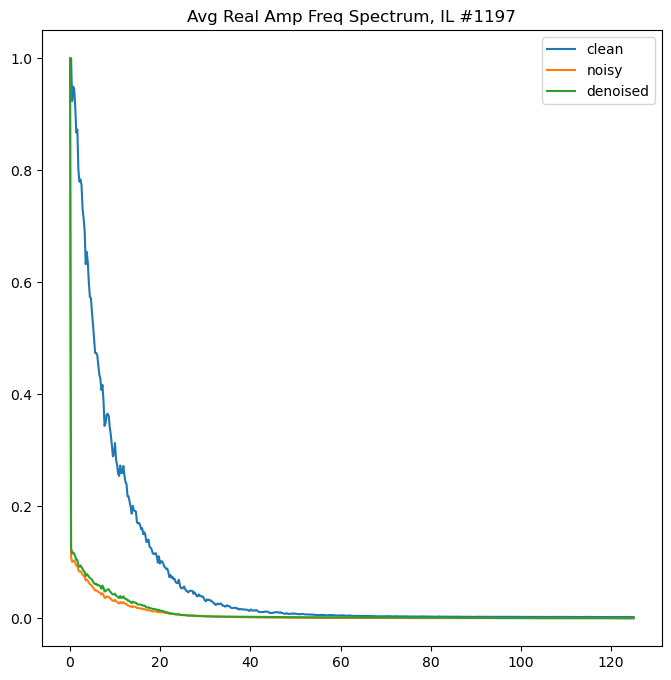

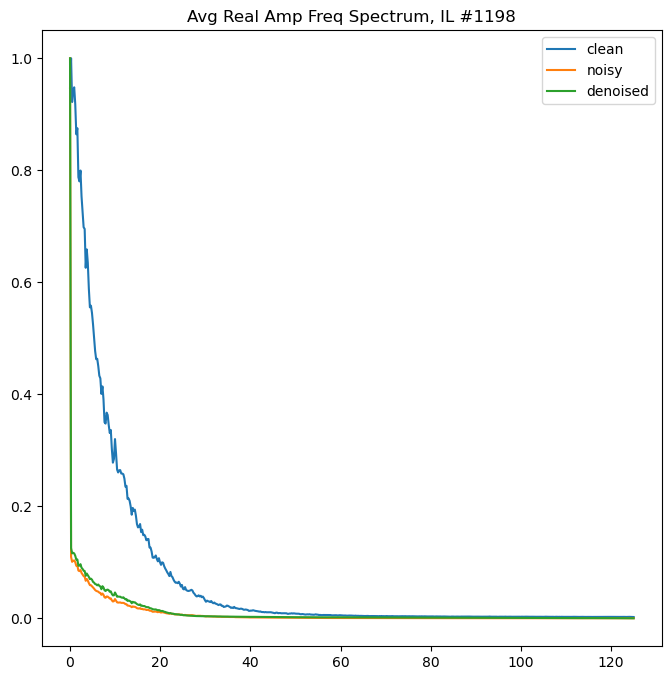

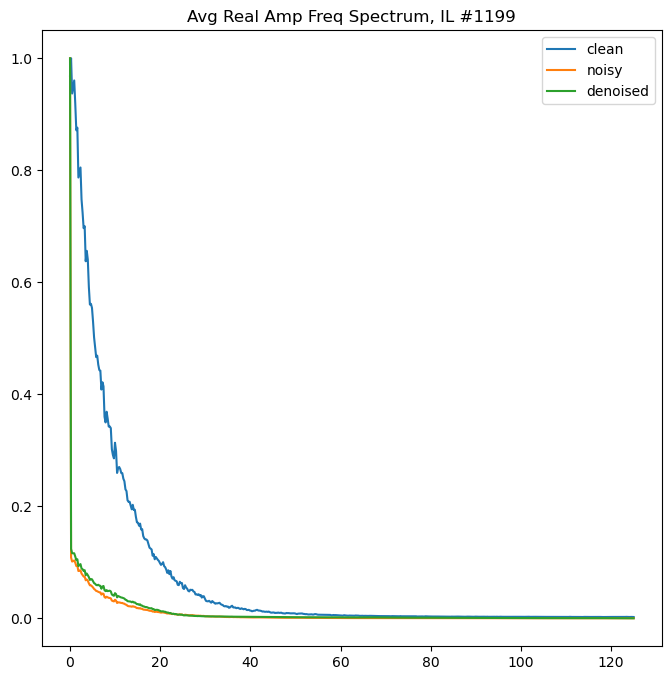

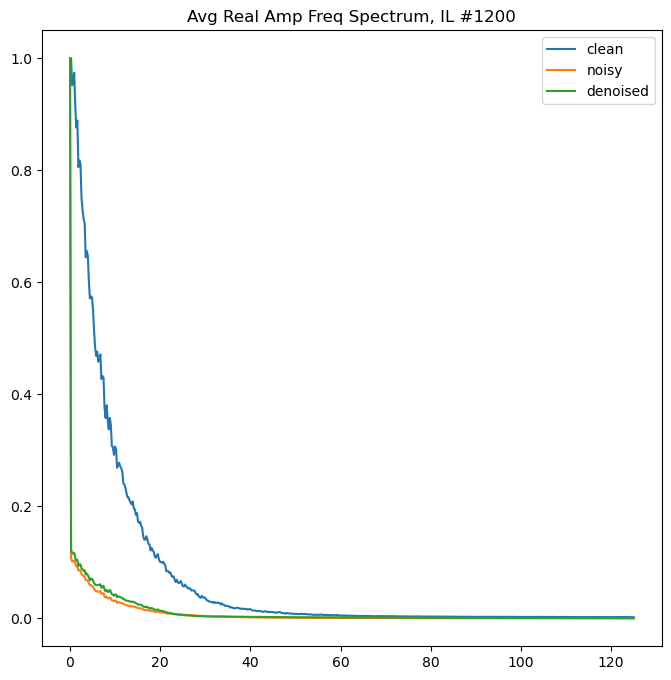

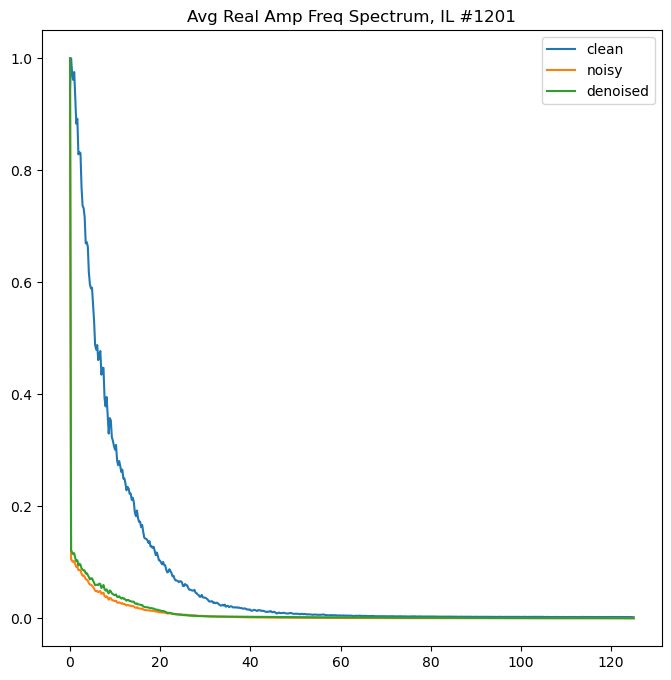

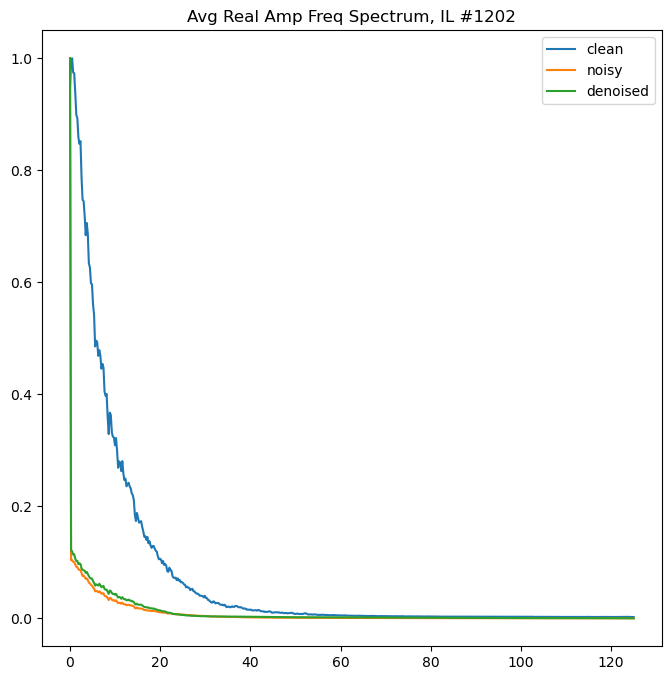

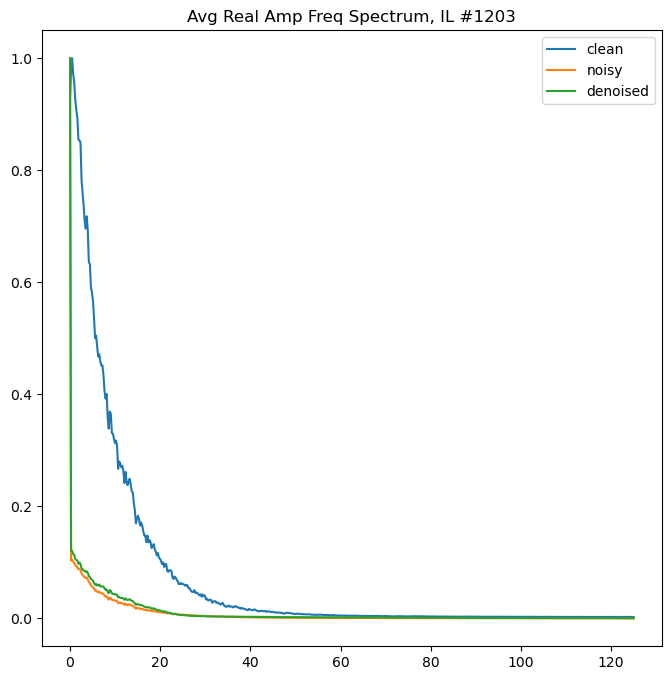

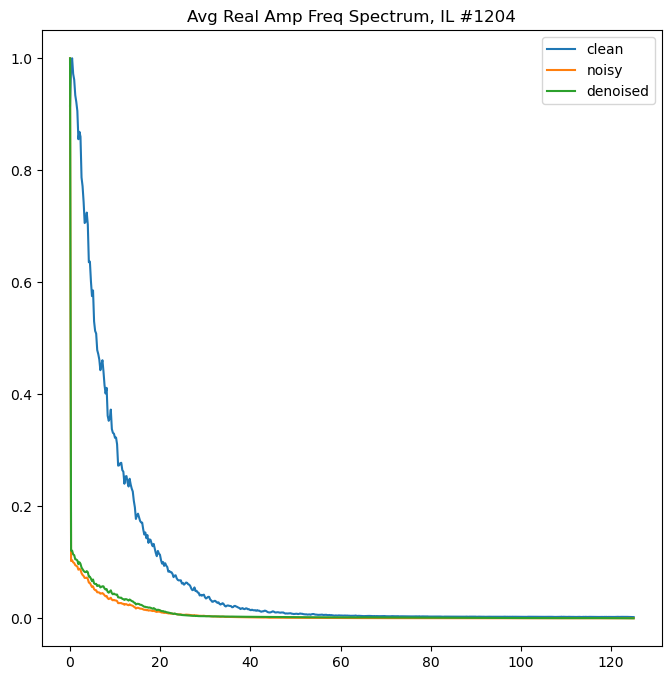

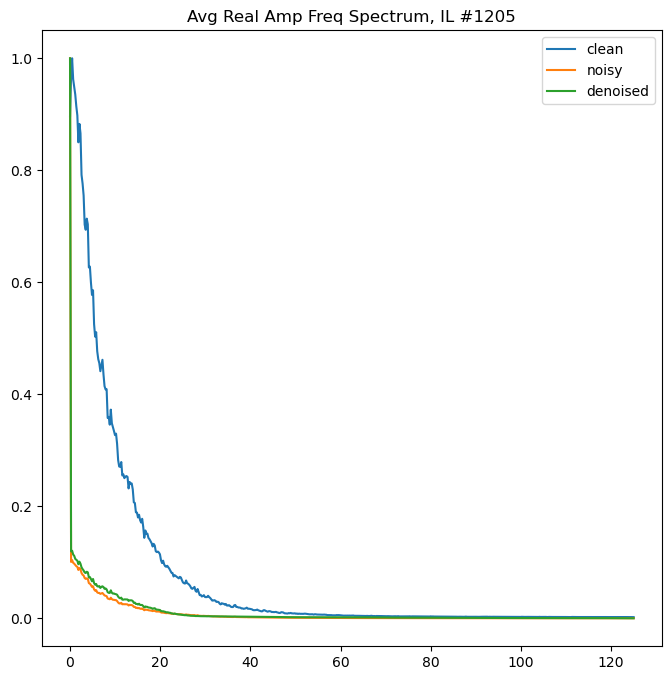

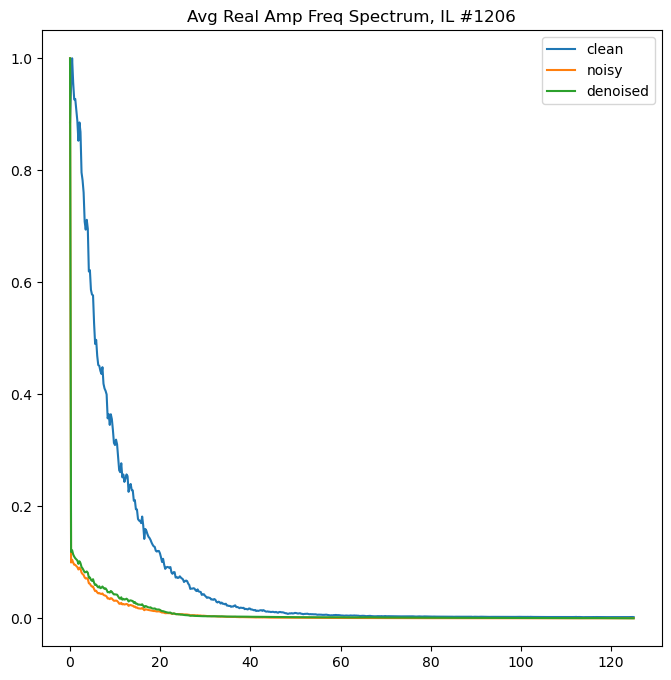

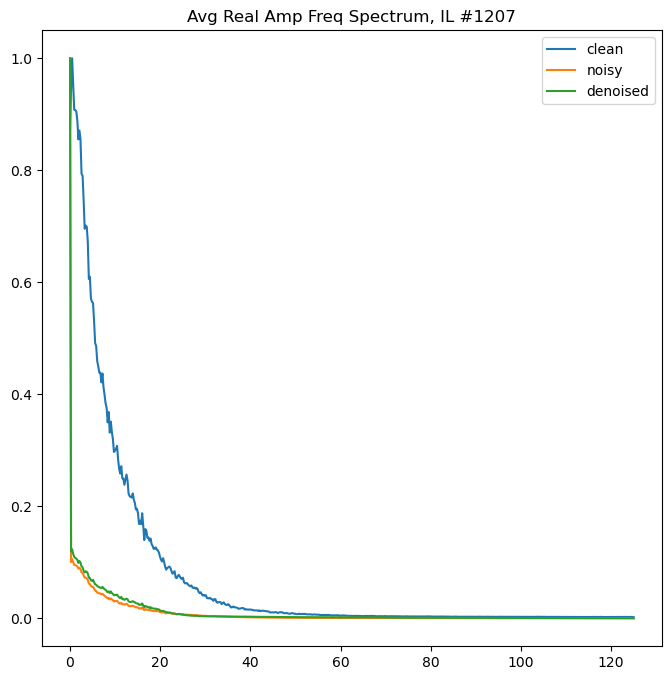

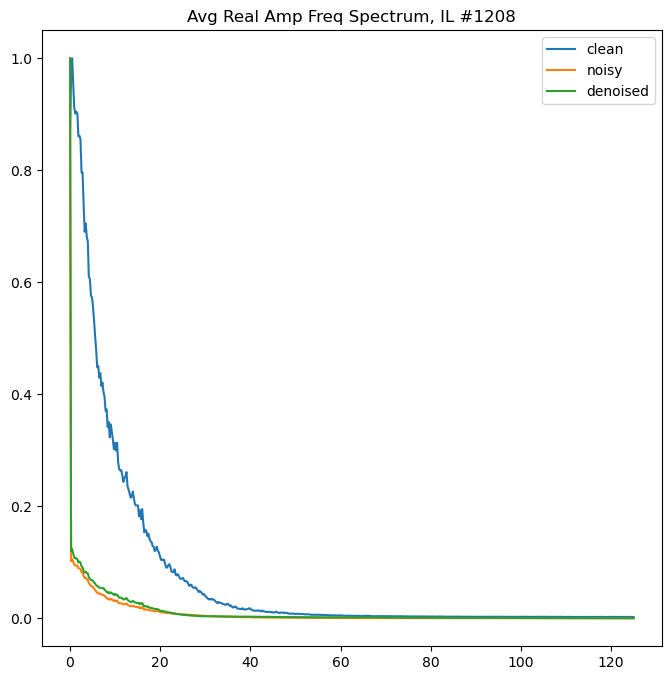

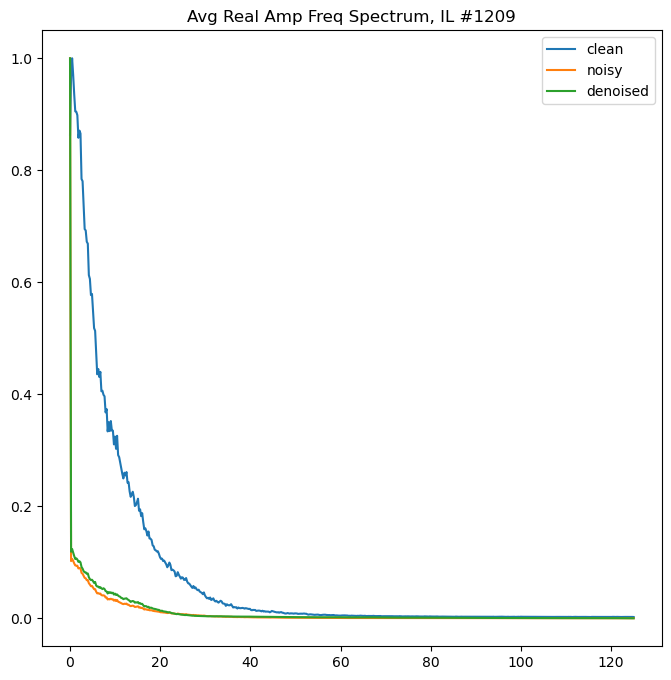

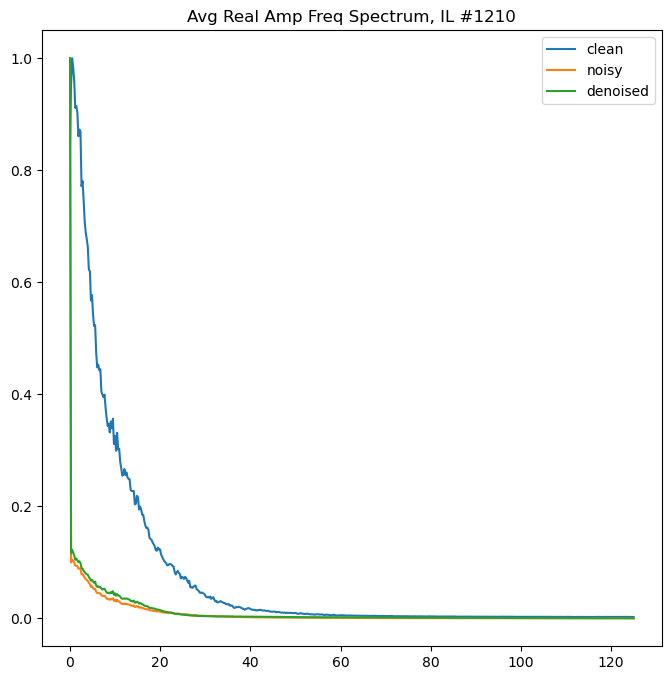

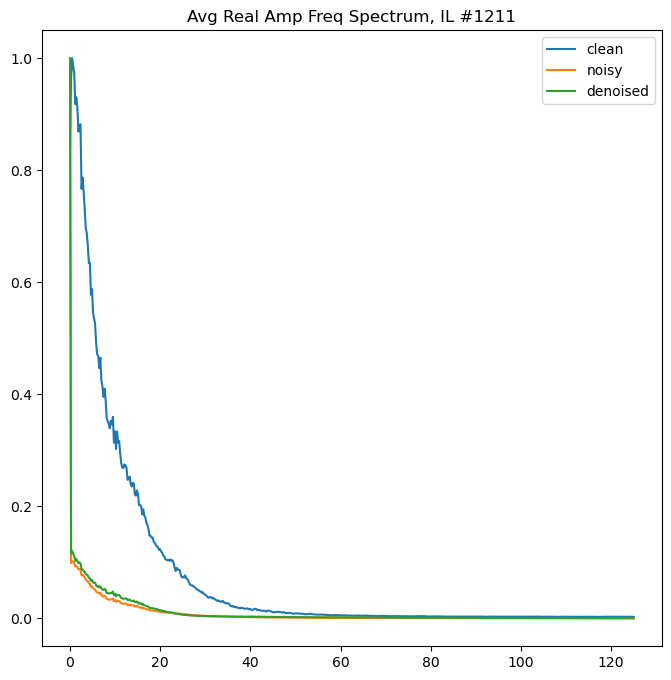

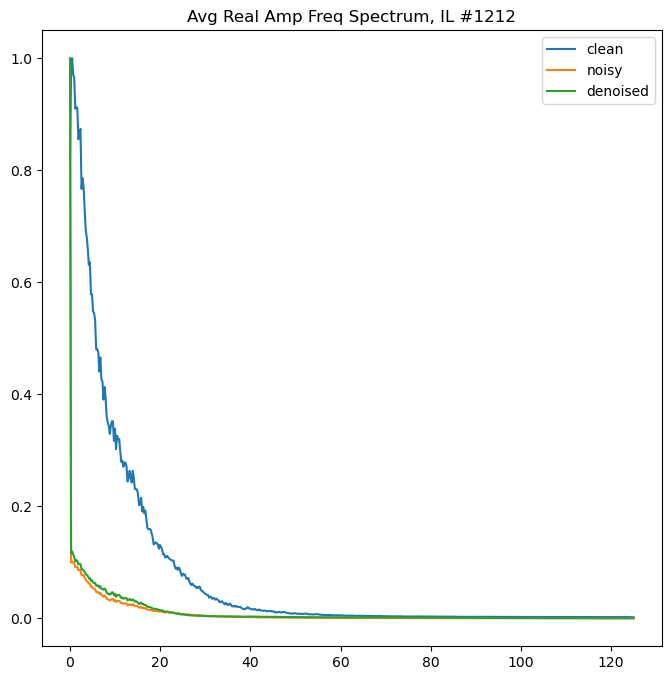

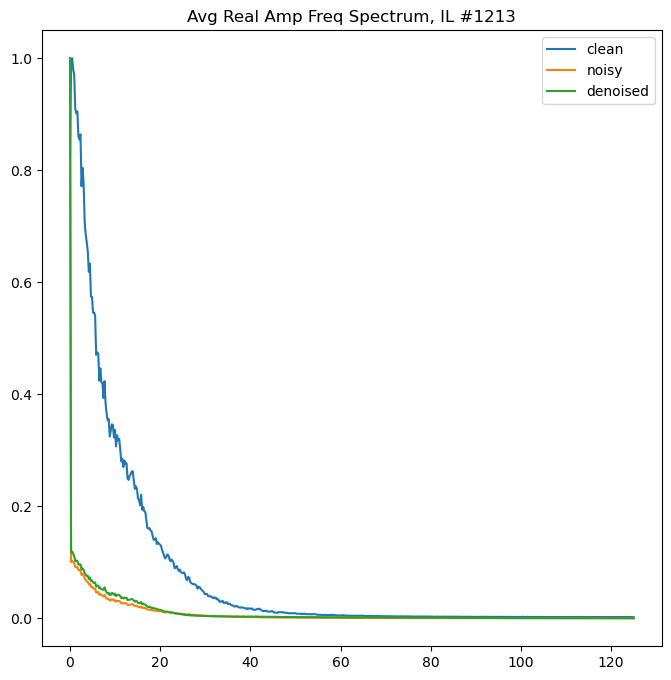

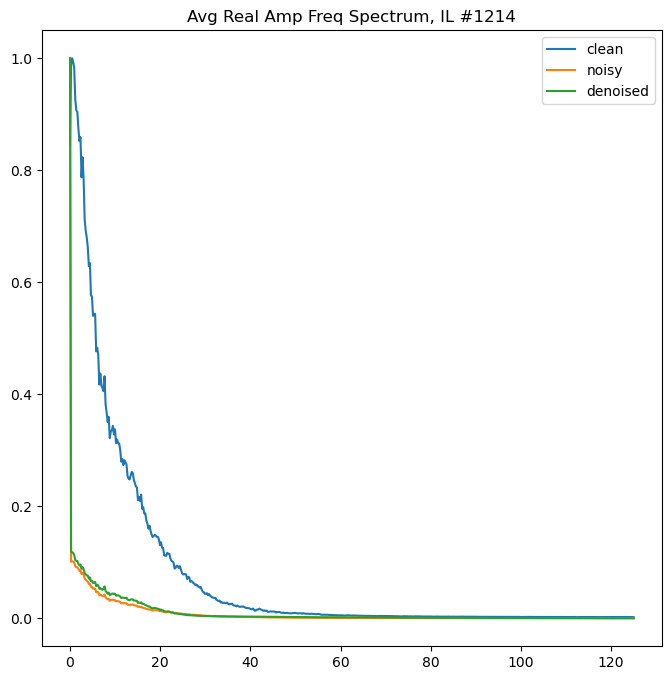

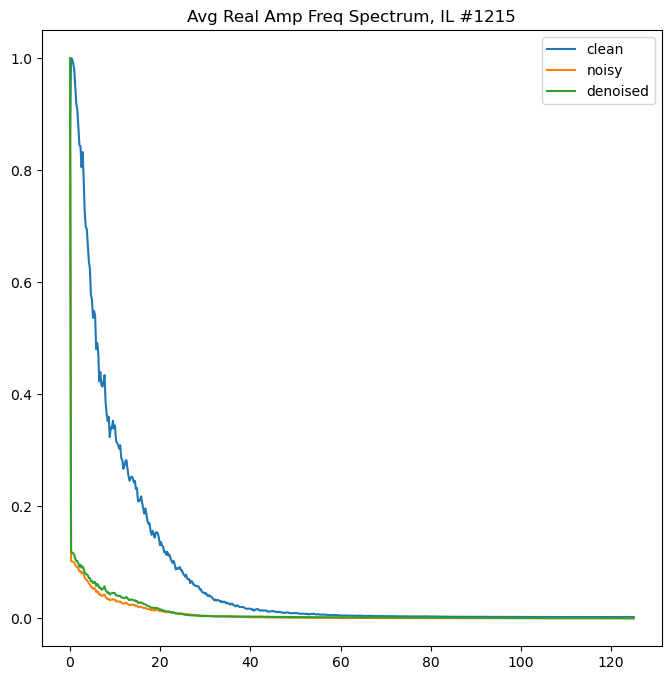

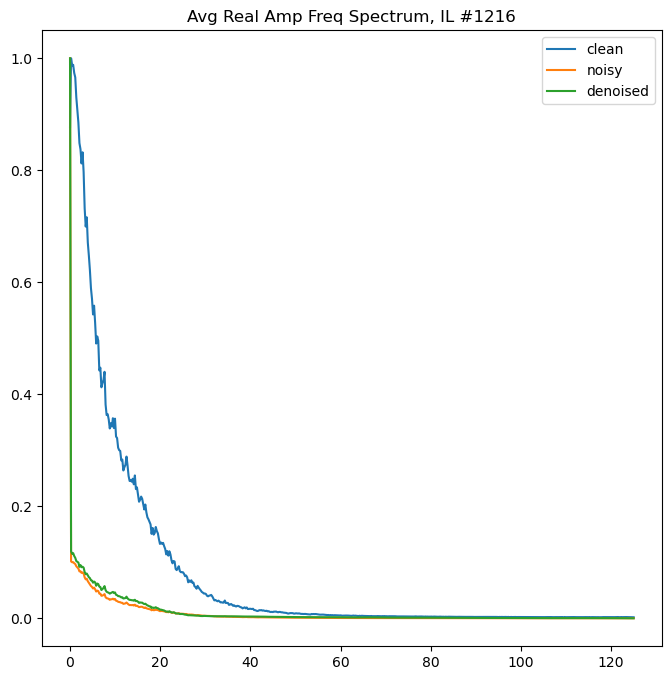

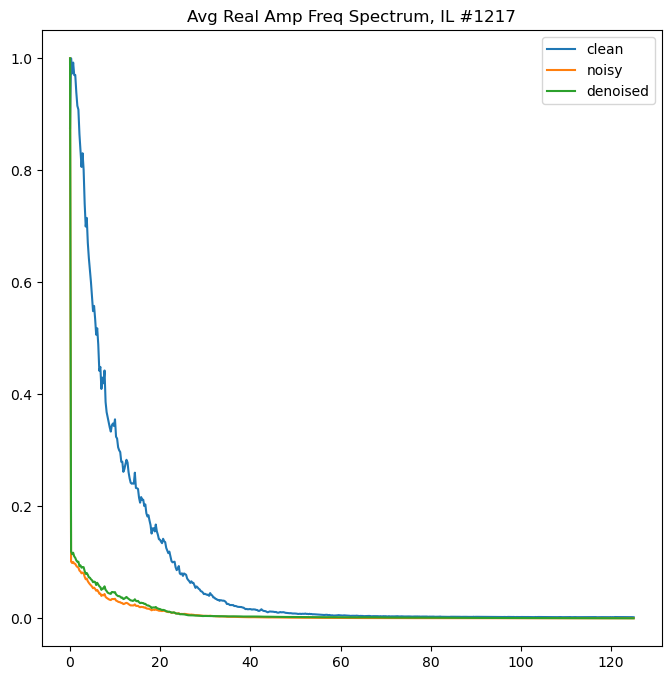

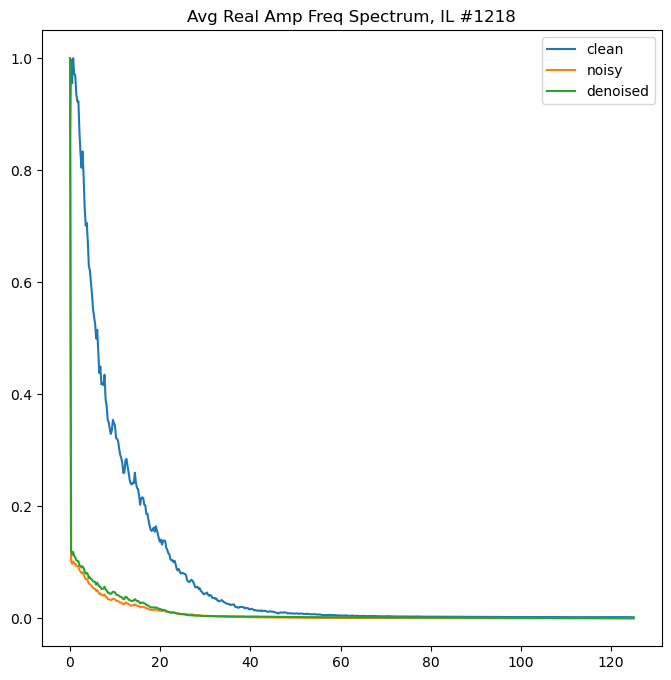

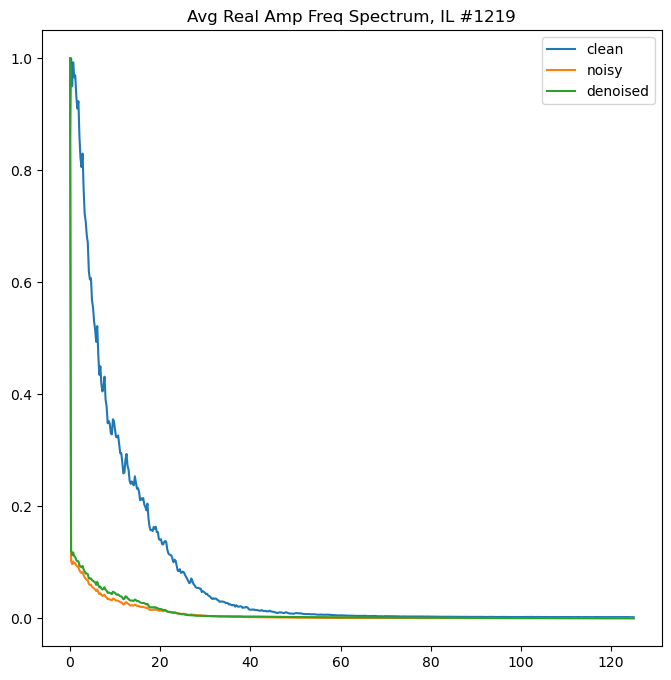

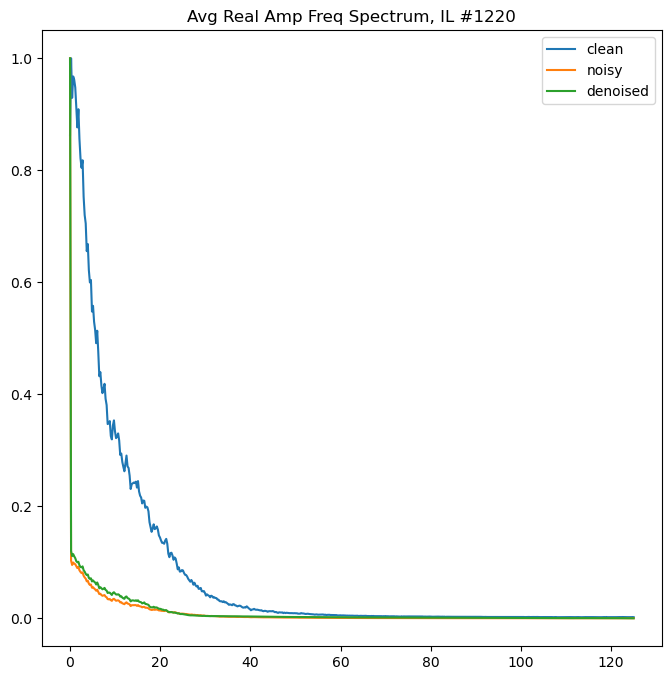

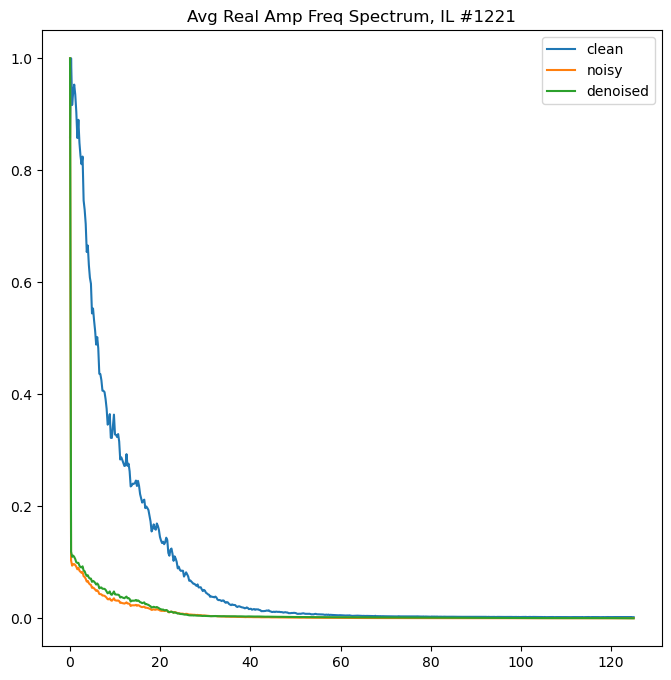

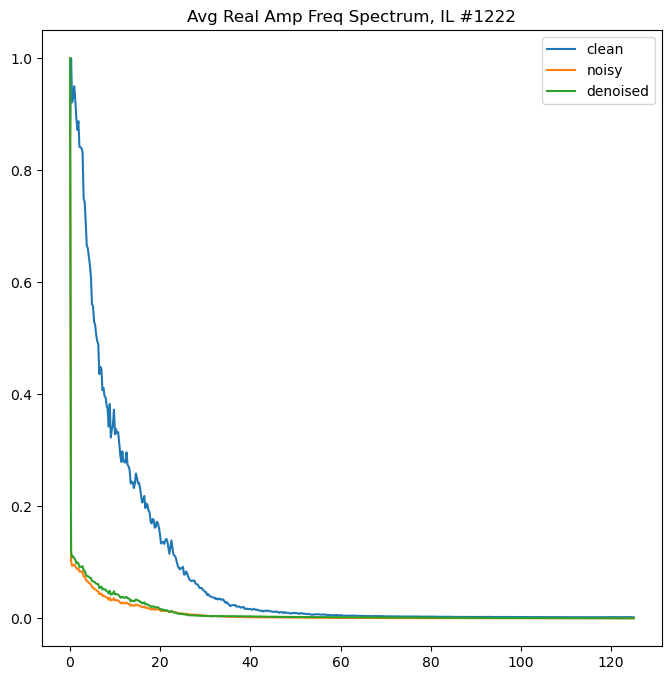

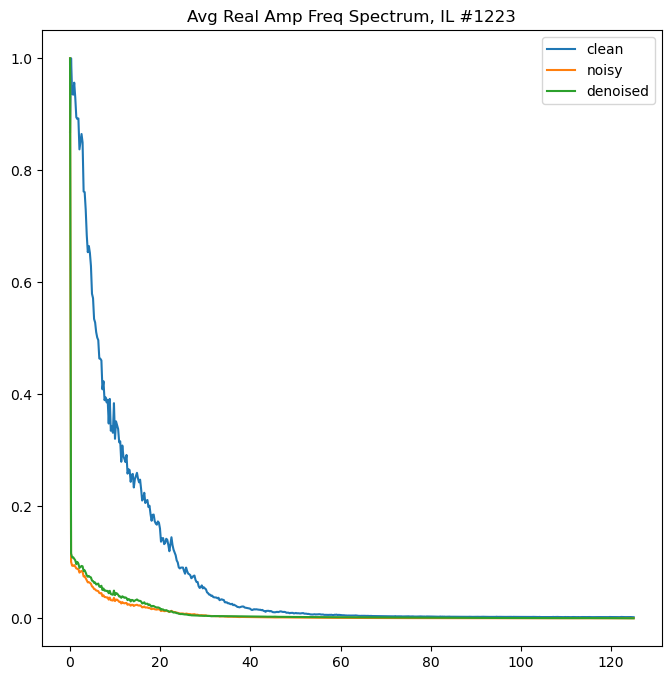

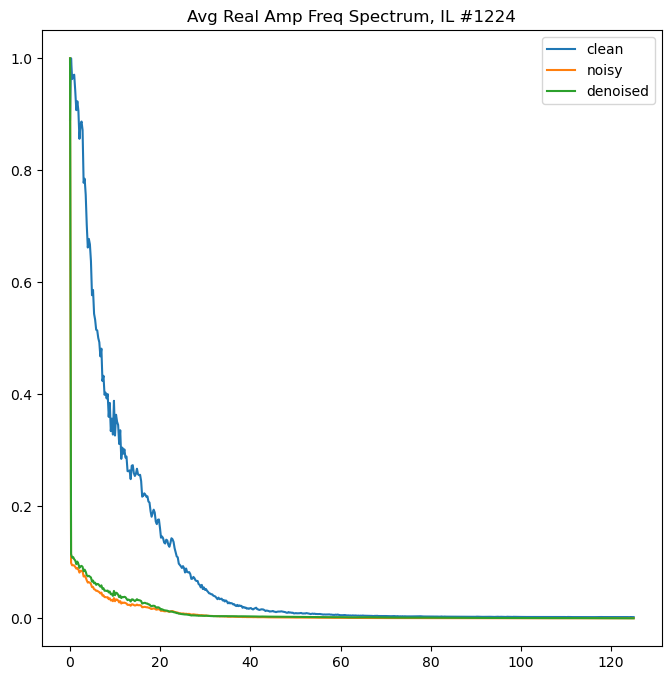

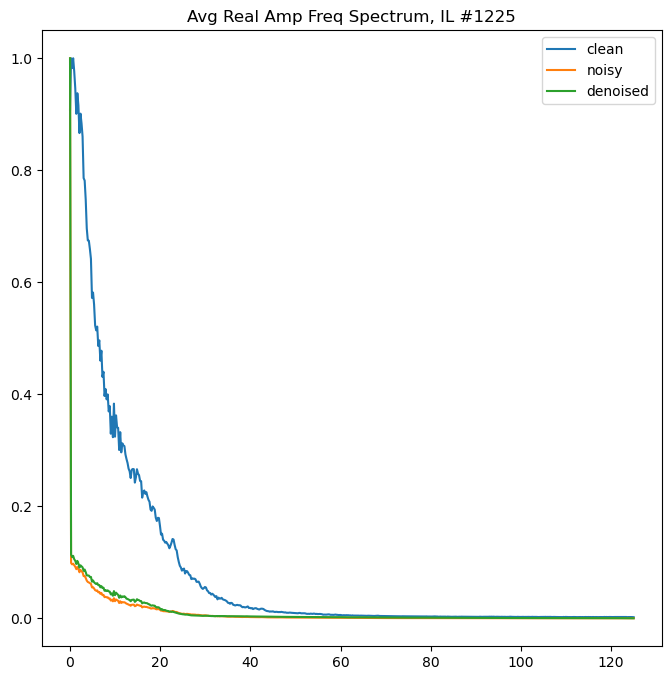

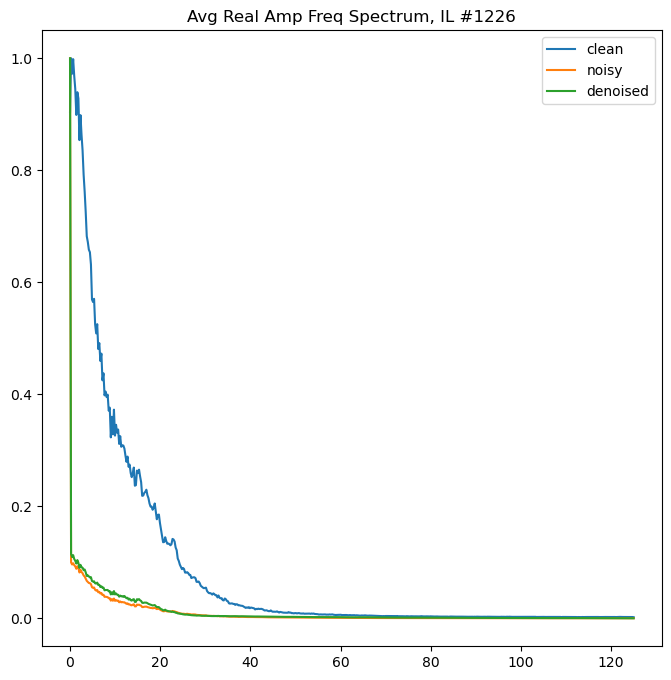

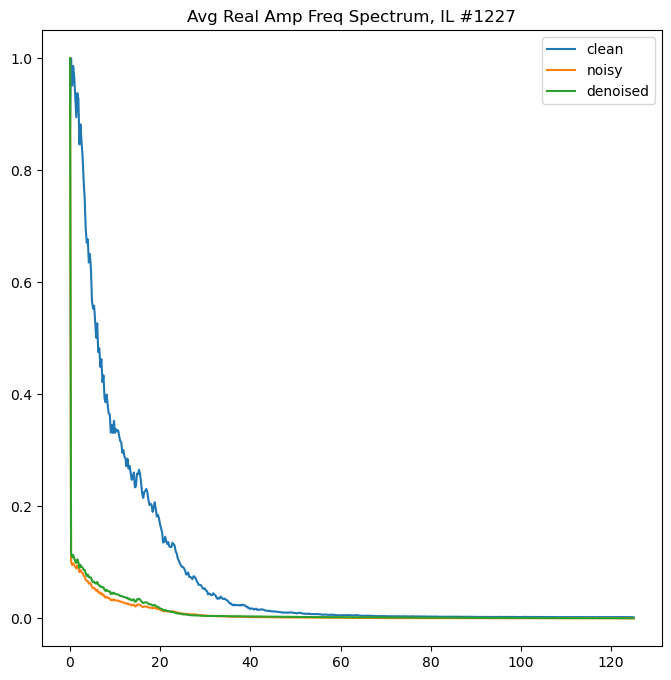

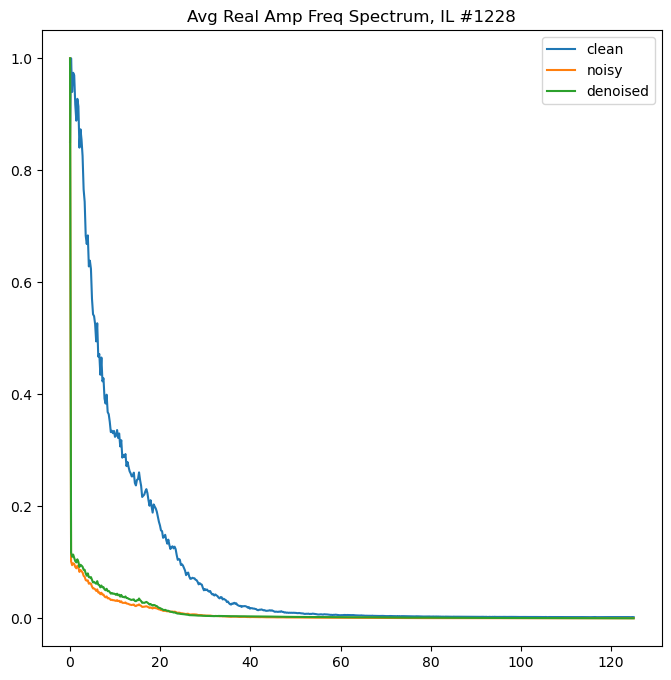

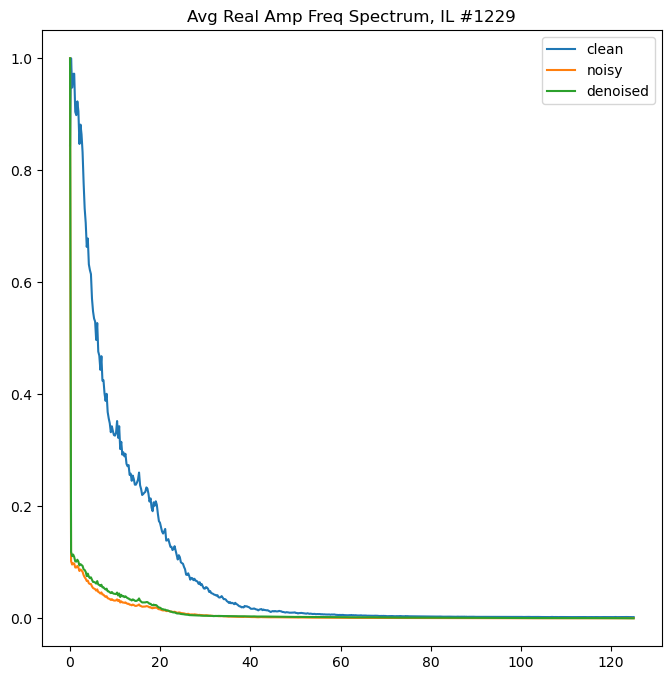

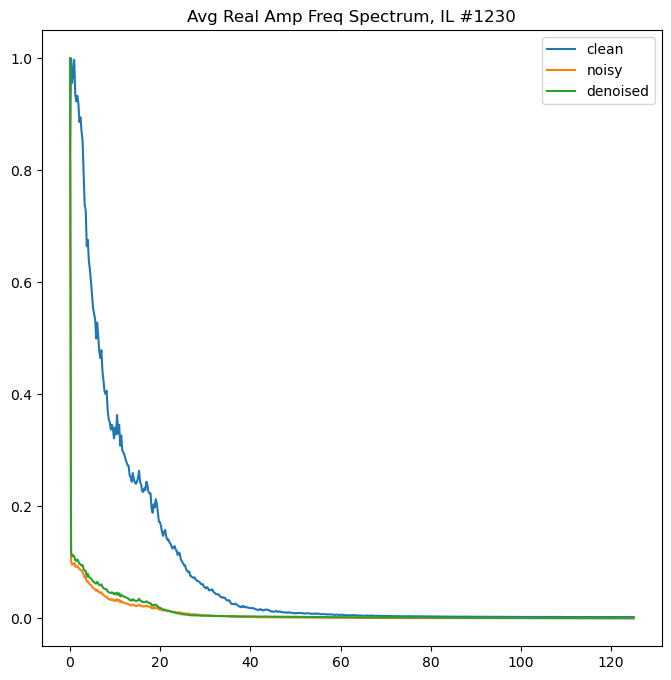

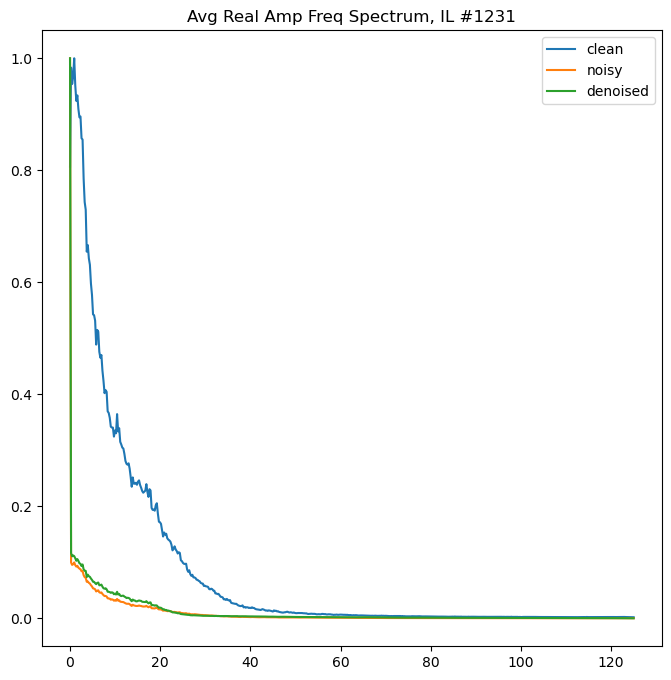

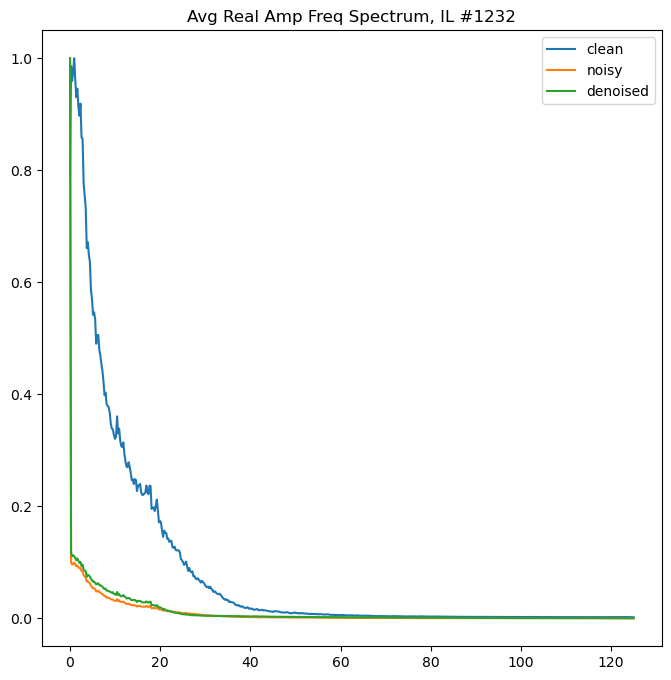

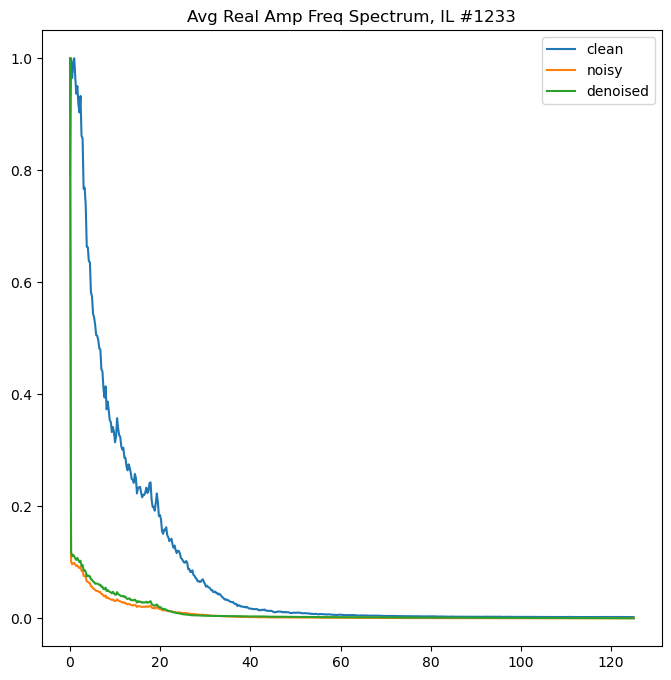

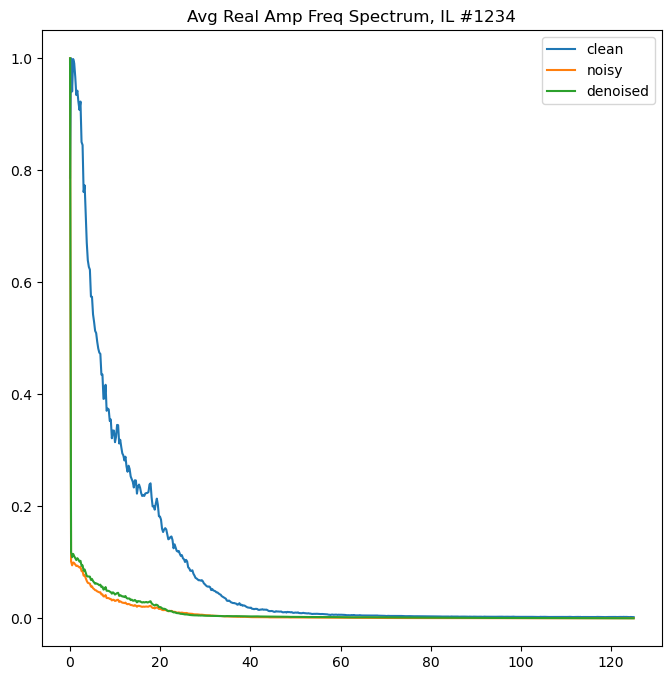

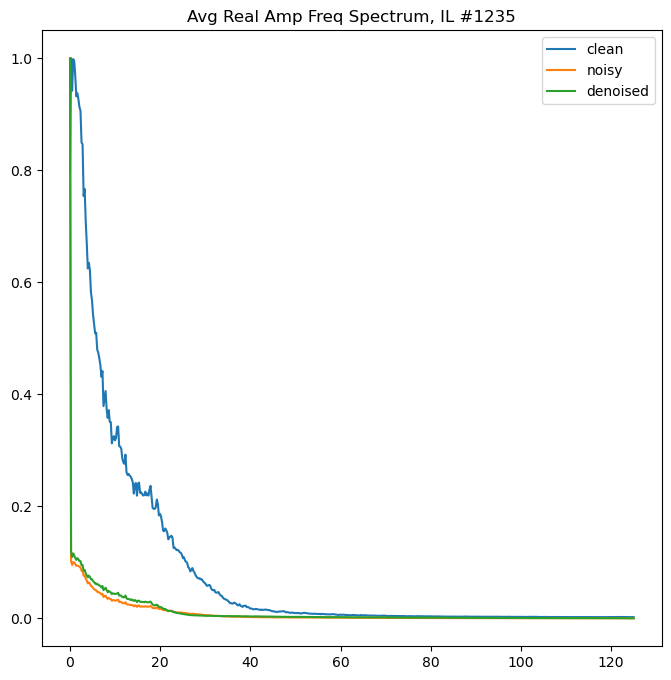

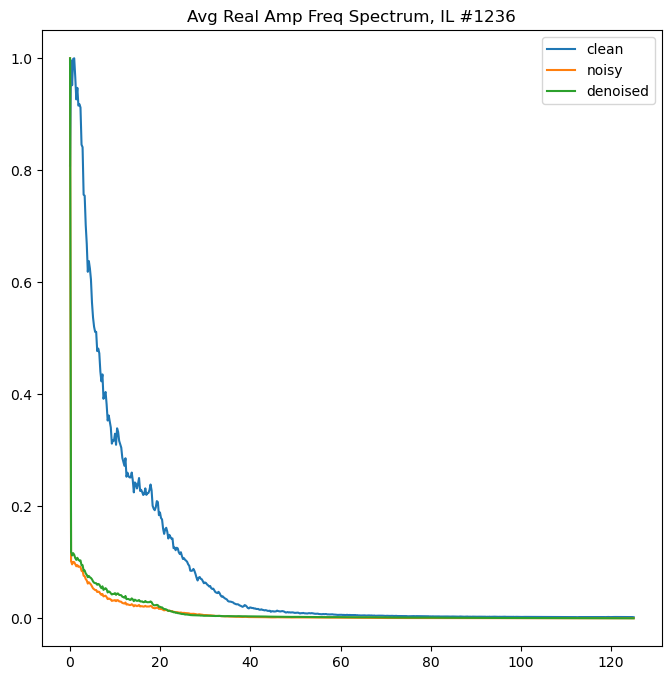

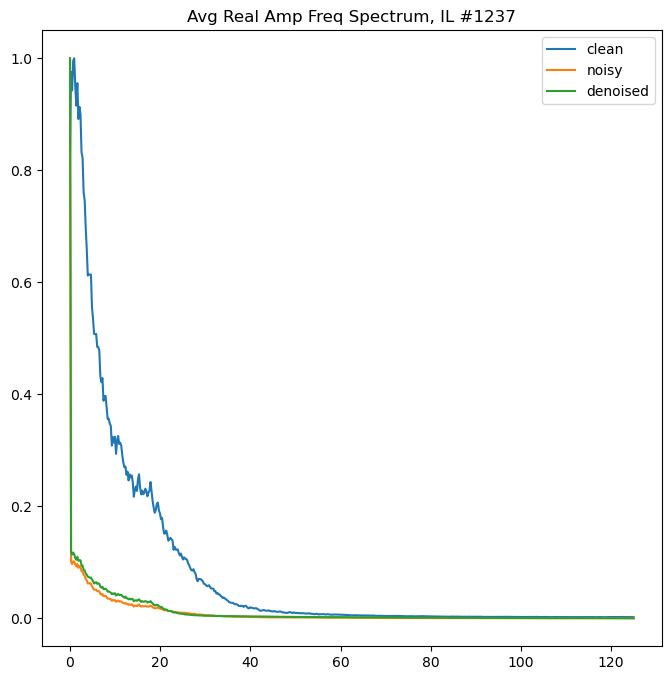

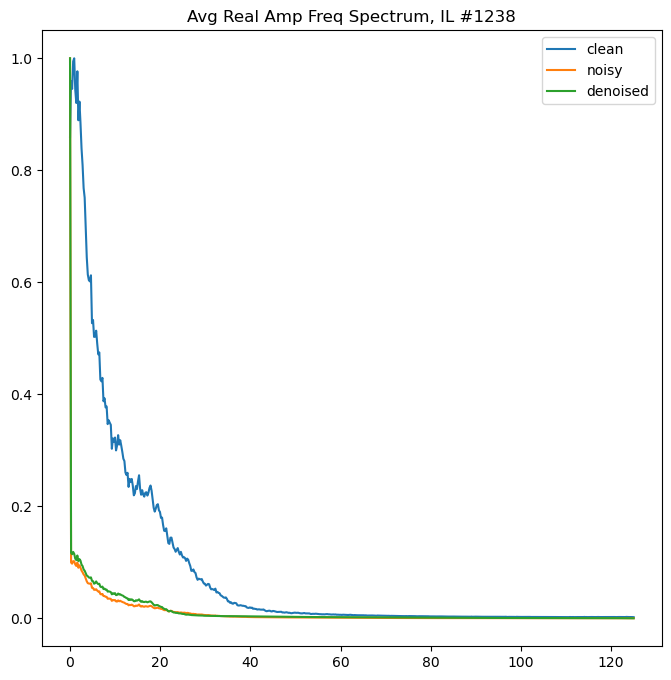

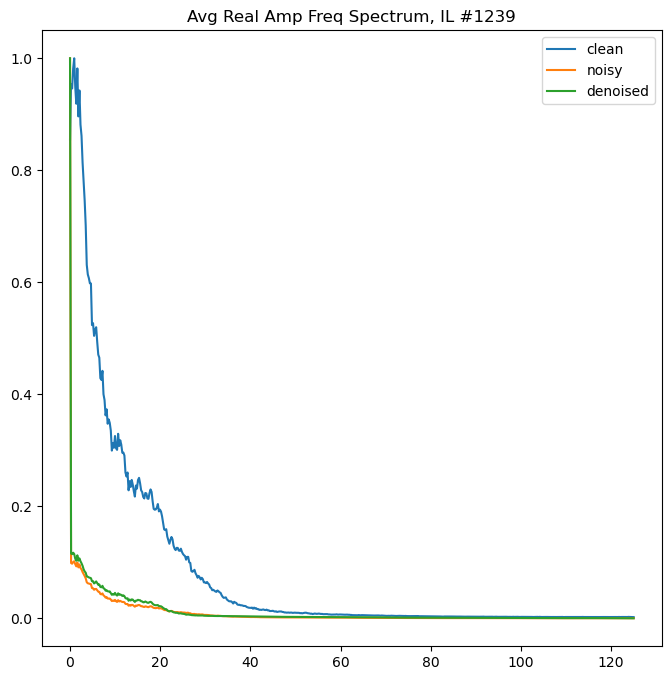

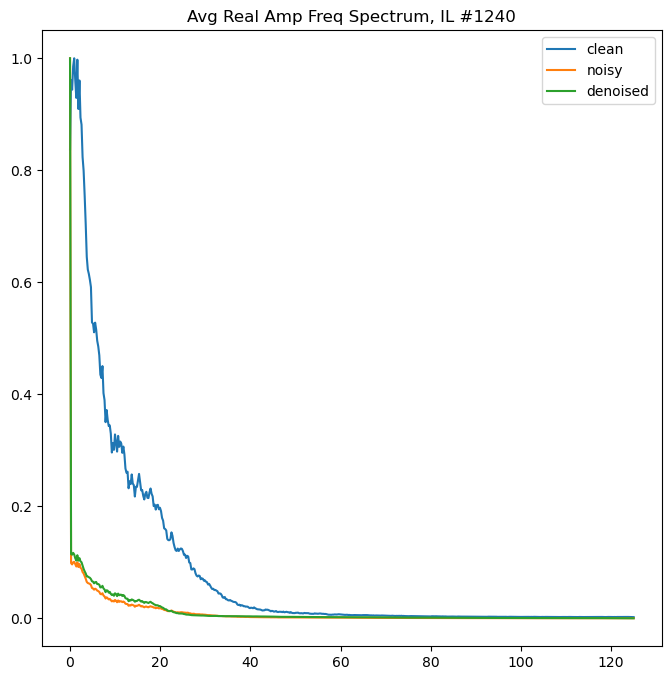

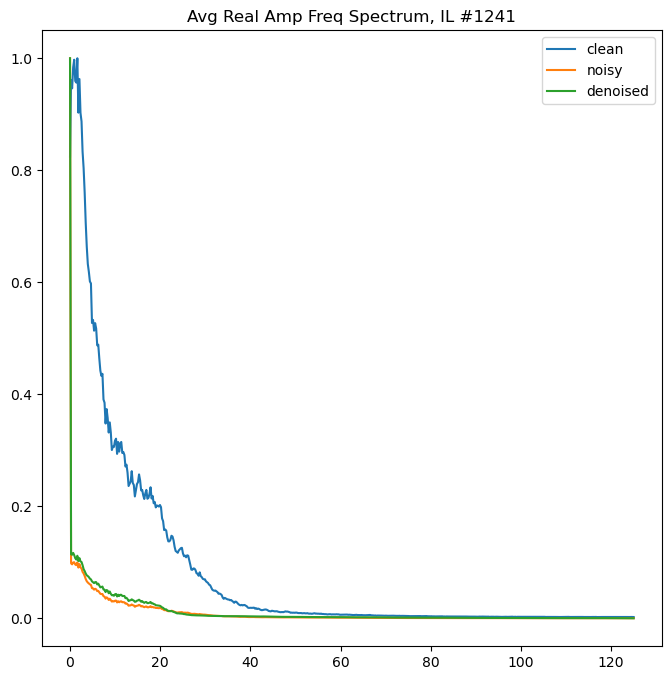

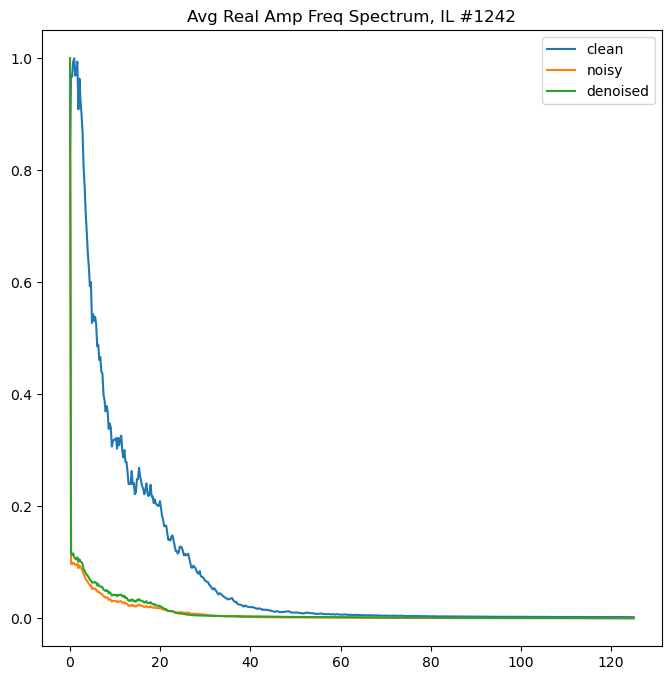

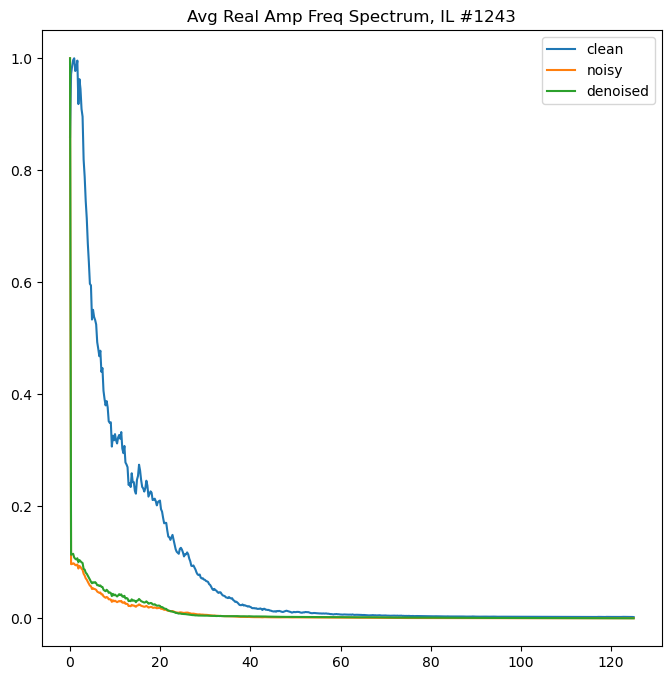

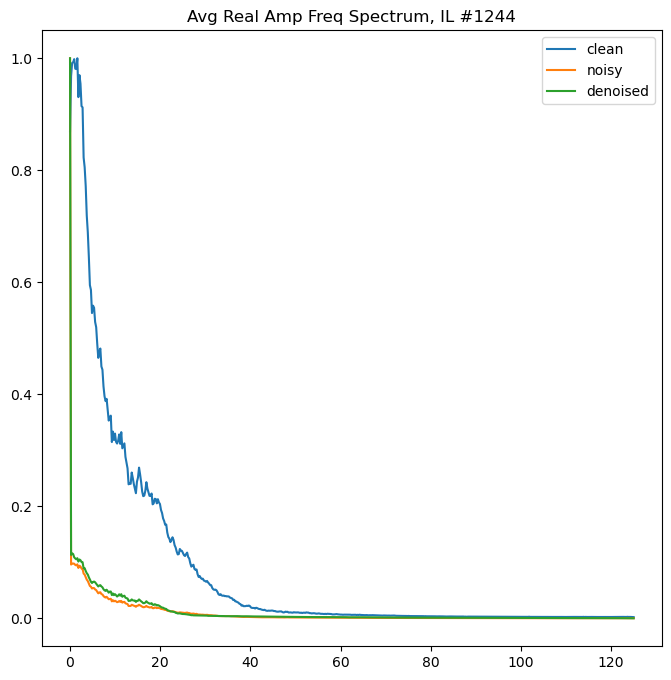

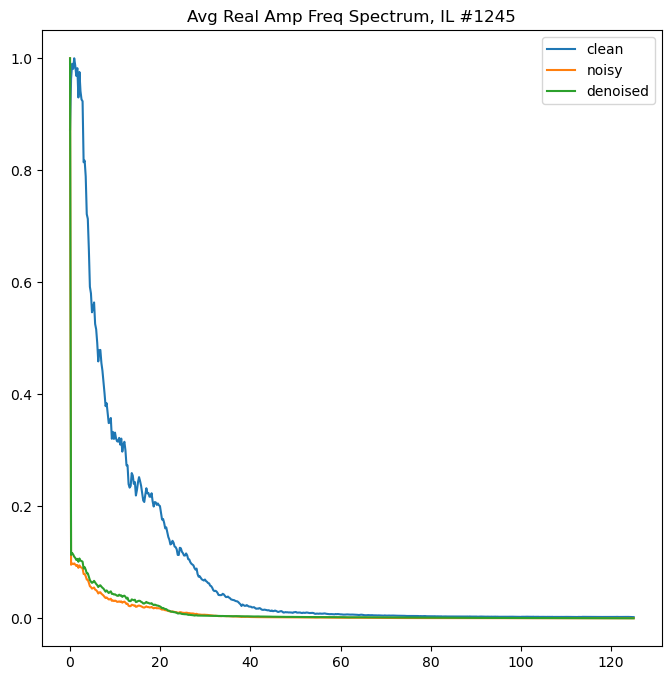

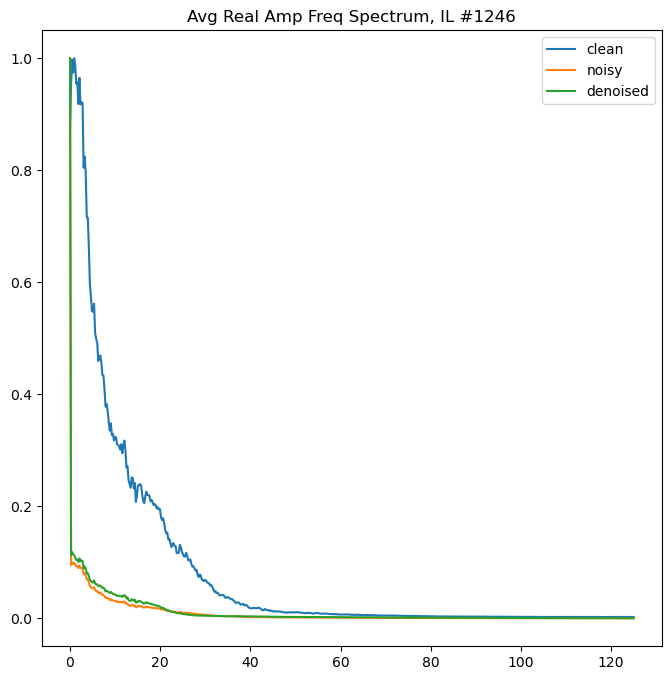

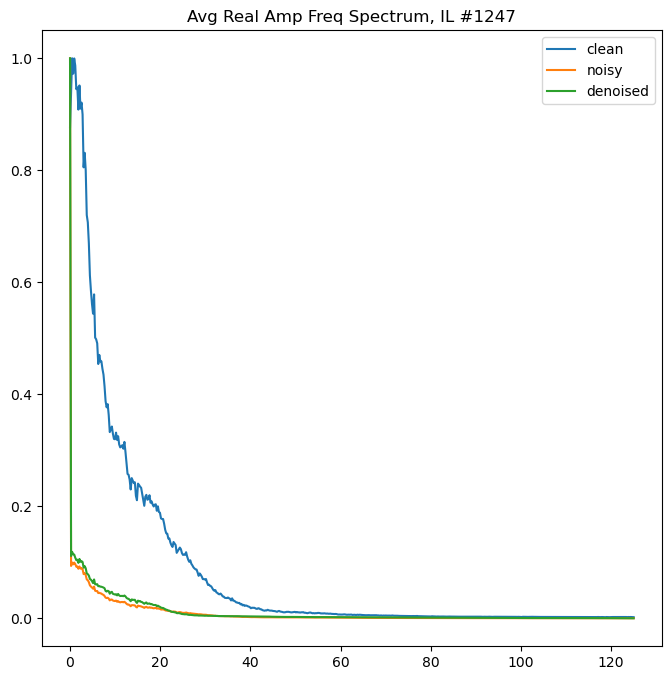

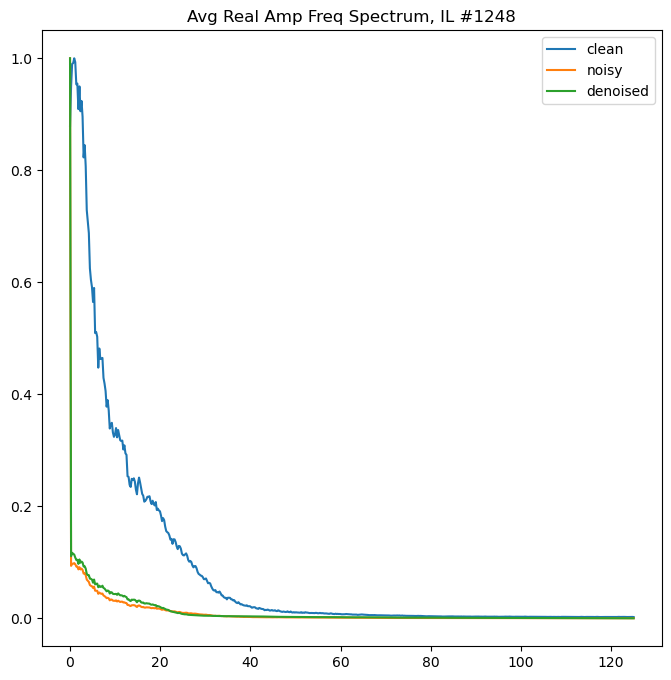

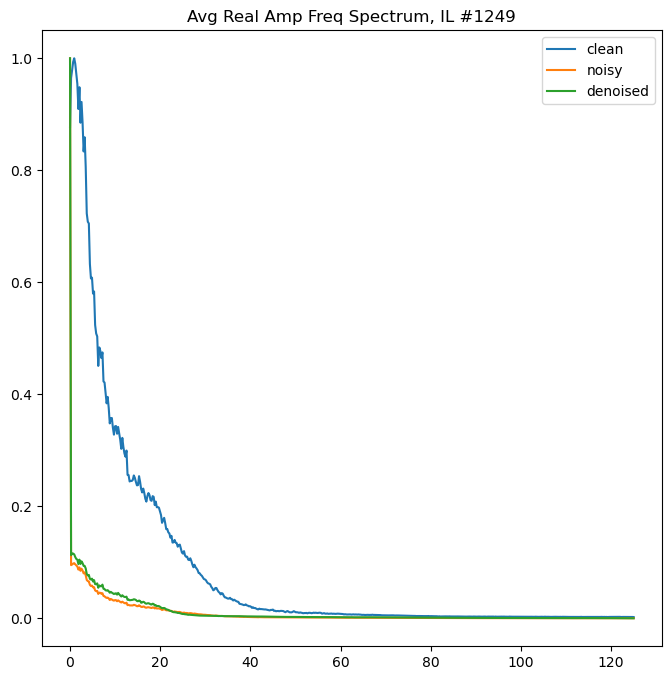

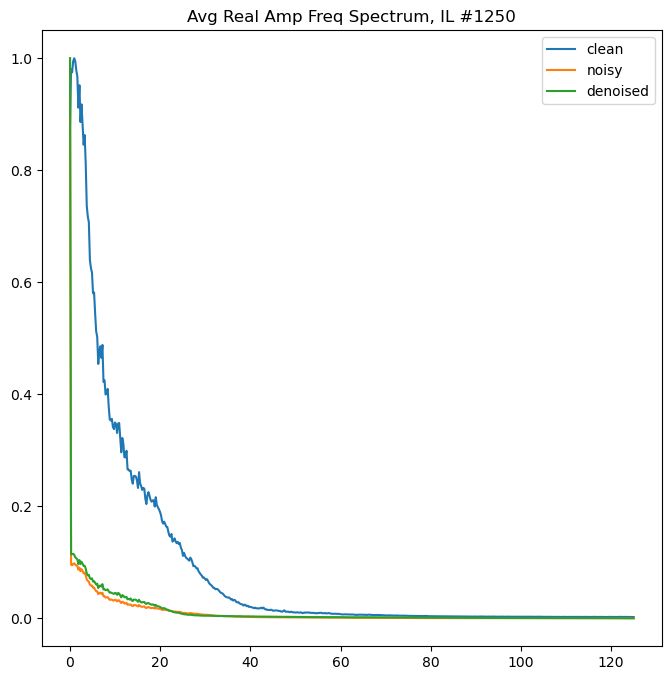

In [49]:
iline_no = 1153
for iline_no in ilines :  
    f_clean, a_clean = spectra_iline(clean, iline_no)
    f_noisy, a_noisy = spectra_iline(noisy,iline_no)
    f_denoised, a_denoised = spectra_iline(denoised, iline_no)

    plt.figure(figsize=(8,8))
    plt.title("Avg Real Amp Freq Spectrum, IL #" + str(iline_no))
    plt.plot(f_clean,a_clean/max(a_clean),label='clean') # normalised values
    plt.plot(f_noisy,a_noisy/max(a_noisy),label='noisy') # normalised values
    plt.plot(f_denoised,a_denoised/max(a_denoised),label='denoised') # normalised values
    plt.legend()
    plt.show()    